<a href="https://colab.research.google.com/github/Datamin-D/Projects/blob/main/Stock_price_prediction_with_base_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [311]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import time
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten,Conv1D,MaxPooling1D,GlobalAveragePooling1D,Reshape
from keras.callbacks import ModelCheckpoint,EarlyStopping

import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from datetime import datetime, timedelta

from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV
 
import re

import statsmodels.formula.api as smf

In [312]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Importing data frames

In [352]:
import os 
os.chdir('/gdrive/MyDrive/석사 수업/2학기/비즈니스 인포매틱스 세미나/프로젝트/2차 데이터 수집')
cpi_df = pd.read_csv('cpi.csv',parse_dates=["date"]) #소비자물가지수
mc_df_raw = pd.read_csv('시총(백만원).csv',parse_dates=["Symbol Name"], encoding = 'cp949') #시총
# df = pd.read_csv('dfdf.csv',parse_dates=["date"],encoding = 'cp949') # 가공 된 후 dfdf
df = pd.read_csv('dfdf.csv',encoding = 'cp949',parse_dates=["Item Name"]) # 가공 전 dfdf 기본 재무지표, 비율
krrate = pd.read_csv('kr_rate.csv',names=['date','kr_rate'], header=None,parse_dates=["date"])
usrate = pd.read_csv('us_rate.csv',names=['date','us_rate'], header=None,parse_dates=["date"])

# df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,16,18,19,20,21,22,38,40,42,43,44,45,46,57,59,62,64,66,67,68,69,70,86,88,90,91,92,93,94,110,112,114,115,116,117,118,158,160,162,163,164,165,166,182,184,187,188,189,190,206,208,210,211,212,213,214,230,232,234,235,236,237,238,254,256,258,259,260,261,262,278,280,282,283,284,285,286,302,304,307,308,309,310,326,328,331,332,333,334,350,352,354,355,356,357,358,374,376,378,379,380,381,382,398,400,402,403,404,405,406,422,424,426,427,428,429,430,446,448,450,451,452,453,454,475,476,477,478,494,496,498,499,500,501,502,513,515,518,520,523,542,544,547,548,549,550,566,568,570,571,572,573,574,587,590,592,594,595,596,597,598,614,616,618,619,620,621,622,638,640,642,643,644,645,646,662,664,666,667,668,669,670,686,688,691,692,693,694,714,731,734,736,739,740,741,742,758,760,763,764,765,766,782,784,786,787,788,789,790,806,808,810,811,812,813,814,817,818,819,820,821,822,823,824,828,830,832,834,835,836,837,8

# 1.Data Preprocessing for fn guide

## 0) df 형태 변환

In [353]:
df.shape

(90, 11977)

In [354]:
11976/24

499.0

In [355]:
df.columns[:25]

Index(['Item Name', '유동자산(천원)', '비유동자산(천원)', '유동부채(천원)', '비유동부채(천원)',
       '총자본(천원)', '매출액(천원)', '당기순이익(천원)', '영업활동으로인한현금흐름(천원)', '자기자본비율(%)',
       '매출총이익률(%)', '부채비율(%)', '당좌자산(천원)', '매출액증가율(전분기)(%)', '매출액증가율(전년동기)(%)',
       '총자산증가율(전분기)(%)', '총자산증가율(전년동기)(%)', '영업이익증가율(전분기)(%)',
       '영업이익증가율(전년동기)(%)', '총자산회전율(회)', '총자산회전율(3년평균)(회)', 'ROE(영업이익)(%)',
       'ROE(영업이익,3년평균)(%)', '매출채권(천원)', '재고자산(천원)'],
      dtype='object')

In [356]:

# date 컬럼 분해 조립은 분해의 역순!
date = df['Item Name'] #90 length
date # 나중에 조립. 행 수만큼 채워넣기.
df = df.drop('Item Name', axis = 1)
df

,유동자산(천원),비유동자산(천원),유동부채(천원),비유동부채(천원),총자본(천원),매출액(천원),당기순이익(천원),영업활동으로인한현금흐름(천원),자기자본비율(%),매출총이익률(%),부채비율(%),당좌자산(천원),매출액증가율(전분기)(%),매출액증가율(전년동기)(%),총자산증가율(전분기)(%),총자산증가율(전년동기)(%),영업이익증가율(전분기)(%),영업이익증가율(전년동기)(%),총자산회전율(회),총자산회전율(3년평균)(회),ROE(영업이익)(%),"ROE(영업이익,3년평균)(%)",매출채권(천원),재고자산(천원),유동자산(천원).1,비유동자산(천원).1,유동부채(천원).1,비유동부채(천원).1,총자본(천원).1,매출액(천원).1,당기순이익(천원).1,영업활동으로인한현금흐름(천원).1,자기자본비율(%).1,매출총이익률(%).1,부채비율(%).1,당좌자산(천원).1,매출액증가율(전분기)(%).1,매출액증가율(전년동기)(%).1,총자산증가율(전분기)(%).1,총자산증가율(전년동기)(%).1,...,자기자본비율(%).497,매출총이익률(%).497,부채비율(%).497,당좌자산(천원).497,매출액증가율(전분기)(%).497,매출액증가율(전년동기)(%).497,총자산증가율(전분기)(%).497,총자산증가율(전년동기)(%).497,영업이익증가율(전분기)(%).497,영업이익증가율(전년동기)(%).497,총자산회전율(회).497,총자산회전율(3년평균)(회).497,ROE(영업이익)(%).497,"ROE(영업이익,3년평균)(%).497",매출채권(천원).497,재고자산(천원).497,유동자산(천원).498,비유동자산(천원).498,유동부채(천원).498,비유동부채(천원).498,총자본(천원).498,매출액(천원).498,당기순이익(천원).498,영업활동으로인한현금흐름(천원).498,자기자본비율(%).498,매출총이익률(%).498,부채비율(%).498,당좌자산(천원).498,매출액증가율(전분기)(%).498,매출액증가율(전년동기)(%).498,총자산증가율(전분기)(%).498,총자산증가율(전년동기)(%).498,영업이익증가율(전분기)(%).498,영업이익증가율(전년동기)(%).498,총자산회전율(회).498,총자산회전율(3년평균)(회).498,ROE(영업이익)(%).498,"ROE(영업이익,3년평균)(%).498",매출채권(천원).498,재고자산(천원).498
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"10,492,005,553","18,686,624,815","10,645,786,938","5,358,159,151","13,174,684,279","32,087,714,365","3,185,702,242","7,194,807,520",45.15,33.07,121.47,"7,008,913,349",NaN,24.5,NaN,21.2,NaN,98.64,1.21,1,58.97,49.11,"3,418,730,565","3,483,092,204","5,300,661,369","20,484,418,099","8,469,232,752","8,838,187,328","8,477,659,388","9,557,712,963","260,299,592","1,735,544,193",32.88,20.80,204.15,"3,102,453,206",NaN,8.65,NaN,56.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"10,492,005,553","18,686,624,815","10,645,786,938","5,358,159,151","13,174,684,279","32,087,714,365","3,185,702,242","7,194,807,520",45.15,33.07,121.47,"7,008,913,349",NaN,24.5,NaN,21.2,NaN,98.64,1.21,1,58.97,49.11,"3,418,730,565","3,483,092,204","5,300,661,369","20,484,418,099","8,469,232,752","8,838,187,328","8,477,659,388","9,557,712,963","260,299,592","1,735,544,193",32.88,20.80,204.15,"3,102,453,206",NaN,8.65,NaN,56.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,"186,136,845,000","171,822,654,000","61,863,721,000","26,287,961,000","269,807,817,000","108,291,320,000","10,440,009,000","26,628,032,000",75.37,38.39,32.67,"156,491,316,000",NaN,-0.2,NaN,4.38,NaN,13.74,0.61,0.69,10.96,16.07,"32,989,762,000","29,645,529,000","17,362,825,000","51,896,472,000","9,595,472,000","10,260,949,000","49,402,87

In [357]:
#2 지표들 행으로 쌓기. date 컬럼은 제외.
bs = pd.DataFrame(data = [],columns= [ '유동자산(천원)', '비유동자산(천원)', '유동부채(천원)', '비유동부채(천원)',
       '총자본(천원)', '매출액(천원)', '당기순이익(천원)', '영업활동으로인한현금흐름(천원)', '자기자본비율(%)',
       '매출총이익률(%)', '부채비율(%)', '당좌자산(천원)', '매출액증가율(전분기)(%)', '매출액증가율(전년동기)(%)',
       '총자산증가율(전분기)(%)', '총자산증가율(전년동기)(%)', '영업이익증가율(전분기)(%)',
       '영업이익증가율(전년동기)(%)', '총자산회전율(회)', '총자산회전율(3년평균)(회)', 'ROE(영업이익)(%)',
       'ROE(영업이익,3년평균)(%)', '매출채권(천원)', '재고자산(천원)'])
#for i in range(11976):
start = 0
for i in range(499):
    start = i * 24
    end = (i+1) * 24  
    temp_df = df.iloc[:,start:end]
    temp_df.columns = bs.columns
    # bs = bs.append(temp_df,ignore_index= True)
    bs = pd.concat([bs,temp_df],axis = 0)
    bs = bs.reset_index(drop = True)
    # print(start,":",end)
# print(bs)
# 잘 합쳐짐.


In [358]:
bs
# bs.reset_index(drop = True)

,유동자산(천원),비유동자산(천원),유동부채(천원),비유동부채(천원),총자본(천원),매출액(천원),당기순이익(천원),영업활동으로인한현금흐름(천원),자기자본비율(%),매출총이익률(%),부채비율(%),당좌자산(천원),매출액증가율(전분기)(%),매출액증가율(전년동기)(%),총자산증가율(전분기)(%),총자산증가율(전년동기)(%),영업이익증가율(전분기)(%),영업이익증가율(전년동기)(%),총자산회전율(회),총자산회전율(3년평균)(회),ROE(영업이익)(%),"ROE(영업이익,3년평균)(%)",매출채권(천원),재고자산(천원)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"10,492,005,553","18,686,624,815","10,645,786,938","5,358,159,151","13,174,684,279","32,087,714,365","3,185,702,242","7,194,807,520",45.15,33.07,121.47,"7,008,913,349",NaN,24.5,NaN,21.2,NaN,98.64,1.21,1,58.97,49.11,"3,418,730,565","3,483,092,204"
3,"10,492,005,553","18,686,624,815","10,645,786,938","5,358,159,151","13,174,684,279","32,087,714,365","3,185,702,242","7,194,807,520",45.15,33.07,121.47,"7,008,913,349",NaN,24.5,NaN,21.2,NaN,98.64,1.21,1,58.97,49.11,"3,418,730,565","3,483,092,204"
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44907,"78,788,653","28,270,491","10,140,132","1,079,448","95,839,563","143,035,985","19,641,575","14,969,550",89.52,76.77,11.71,"73,202,397",NaN,11.52,NaN,13.38,NaN,-0.23,1.42,1.35,26.69,27.09,"6,088,364","5,586,256"
44908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3) date 컬럼 합체

In [359]:
# 90마다 행에 추가. 
date_df = date
for i in range(498):
  date_df = date_df.append(date)
  date_df = date_df.reset_index(drop = True)


In [360]:
temp = pd.concat([bs,date_df],axis = 1,ignore_index=True)
temp.columns = ['유동자산(천원)', '비유동자산(천원)', '유동부채(천원)', '비유동부채(천원)',
       '총자본(천원)', '매출액(천원)', '당기순이익(천원)', '영업활동으로인한현금흐름(천원)', '자기자본비율(%)',
       '매출총이익률(%)', '부채비율(%)', '당좌자산(천원)', '매출액증가율(전분기)(%)', '매출액증가율(전년동기)(%)',
       '총자산증가율(전분기)(%)', '총자산증가율(전년동기)(%)', '영업이익증가율(전분기)(%)',
       '영업이익증가율(전년동기)(%)', '총자산회전율(회)', '총자산회전율(3년평균)(회)', 'ROE(영업이익)(%)',
       'ROE(영업이익,3년평균)(%)', '매출채권(천원)', '재고자산(천원)','date']
temp

,유동자산(천원),비유동자산(천원),유동부채(천원),비유동부채(천원),총자본(천원),매출액(천원),당기순이익(천원),영업활동으로인한현금흐름(천원),자기자본비율(%),매출총이익률(%),부채비율(%),당좌자산(천원),매출액증가율(전분기)(%),매출액증가율(전년동기)(%),총자산증가율(전분기)(%),총자산증가율(전년동기)(%),영업이익증가율(전분기)(%),영업이익증가율(전년동기)(%),총자산회전율(회),총자산회전율(3년평균)(회),ROE(영업이익)(%),"ROE(영업이익,3년평균)(%)",매출채권(천원),재고자산(천원),date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-03-31
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-06-30
2,"10,492,005,553","18,686,624,815","10,645,786,938","5,358,159,151","13,174,684,279","32,087,714,365","3,185,702,242","7,194,807,520",45.15,33.07,121.47,"7,008,913,349",NaN,24.5,NaN,21.2,NaN,98.64,1.21,1,58.97,49.11,"3,418,730,565","3,483,092,204",1999-09-30
3,"10,492,005,553","18,686,624,815","10,645,786,938","5,358,159,151","13,174,684,279","32,087,714,365","3,185,702,242","7,194,807,520",45.15,33.07,121.47,"7,008,913,349",NaN,24.5,NaN,21.2,NaN,98.64,1.21,1,58.97,49.11,"3,418,730,565","3,483,092,204",1999-12-31
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-30
44906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-30
44907,"78,788,653","28,270,491","10,140,132","1,079,448","95,839,563","143,035,985","19,641,575","14,969,550",89.52,76.77,11.71,"73,202,397",NaN,11.52,NaN,13.38,NaN,-0.23,1.42,1.35,26.69,27.09,"6,088,364","5,586,256",2020-12-31
44908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-31


4) company name 넣기

In [361]:
list(mc_df_raw.columns)

['Symbol Name',
 '삼성전자',
 'SK하이닉스',
 'NAVER',
 '카카오',
 'LG화학',
 '삼성바이오로직스',
 '현대차',
 '삼성SDI',
 '셀트리온',
 '기아',
 'POSCO',
 '현대모비스',
 '삼성물산',
 'SK이노베이션',
 'LG전자',
 'LG생활건강',
 'KB금융',
 'SK텔레콤',
 '신한지주',
 'SK',
 '엔씨소프트',
 '셀트리온헬스케어',
 '한국전력',
 '아모레퍼시픽',
 '삼성생명',
 'LG',
 '삼성에스디에스',
 '하나금융지주',
 '삼성전기',
 '넷마블',
 '대한항공',
 'S-Oil',
 'KT&G',
 '포스코케미칼',
 '하이브',
 '삼성화재',
 '두산중공업',
 '한국조선해양',
 'SK바이오팜',
 '한온시스템',
 '롯데케미칼',
 'KT',
 '한화솔루션',
 '우리금융지주',
 '고려아연',
 'LG디스플레이',
 '기업은행',
 '현대글로비스',
 'CJ제일제당',
 'LG유플러스',
 '현대제철',
 '한국타이어앤테크놀로지',
 '아모레G',
 '금호석유',
 '현대건설',
 '미래에셋증권',
 '강원랜드',
 '한국금융지주',
 '코웨이',
 '현대중공업지주',
 '한진칼',
 '셀트리온제약',
 'LG이노텍',
 'SKC',
 '두산밥캣',
 '오리온',
 '한미사이언스',
 '유한양행',
 '이마트',
 '롯데지주',
 'GS',
 '삼성중공업',
 '삼성엔지니어링',
 '쌍용C&E',
 'F&F',
 '펄어비스',
 '에코프로비엠',
 '삼성증권',
 '신풍제약',
 '대우조선해양',
 '한미약품',
 '호텔신라',
 '삼성카드',
 '녹십자',
 'CJ대한통운',
 '대우건설',
 'CJ ENM',
 'GS건설',
 'NH투자증권',
 '에이치엘비',
 '팬오션',
 'DB손해보험',
 '한국가스공사',
 '롯데쇼핑',
 '씨에스윈드',
 '현대미포조선',
 '휠라홀딩스',
 '한국항공우주',
 '현대오토에버',
 '두산인프라코어',
 'SK머티

In [362]:
comp_list = list(mc_df_raw.columns)
comp_list.remove('Symbol Name')
comp_list

['삼성전자',
 'SK하이닉스',
 'NAVER',
 '카카오',
 'LG화학',
 '삼성바이오로직스',
 '현대차',
 '삼성SDI',
 '셀트리온',
 '기아',
 'POSCO',
 '현대모비스',
 '삼성물산',
 'SK이노베이션',
 'LG전자',
 'LG생활건강',
 'KB금융',
 'SK텔레콤',
 '신한지주',
 'SK',
 '엔씨소프트',
 '셀트리온헬스케어',
 '한국전력',
 '아모레퍼시픽',
 '삼성생명',
 'LG',
 '삼성에스디에스',
 '하나금융지주',
 '삼성전기',
 '넷마블',
 '대한항공',
 'S-Oil',
 'KT&G',
 '포스코케미칼',
 '하이브',
 '삼성화재',
 '두산중공업',
 '한국조선해양',
 'SK바이오팜',
 '한온시스템',
 '롯데케미칼',
 'KT',
 '한화솔루션',
 '우리금융지주',
 '고려아연',
 'LG디스플레이',
 '기업은행',
 '현대글로비스',
 'CJ제일제당',
 'LG유플러스',
 '현대제철',
 '한국타이어앤테크놀로지',
 '아모레G',
 '금호석유',
 '현대건설',
 '미래에셋증권',
 '강원랜드',
 '한국금융지주',
 '코웨이',
 '현대중공업지주',
 '한진칼',
 '셀트리온제약',
 'LG이노텍',
 'SKC',
 '두산밥캣',
 '오리온',
 '한미사이언스',
 '유한양행',
 '이마트',
 '롯데지주',
 'GS',
 '삼성중공업',
 '삼성엔지니어링',
 '쌍용C&E',
 'F&F',
 '펄어비스',
 '에코프로비엠',
 '삼성증권',
 '신풍제약',
 '대우조선해양',
 '한미약품',
 '호텔신라',
 '삼성카드',
 '녹십자',
 'CJ대한통운',
 '대우건설',
 'CJ ENM',
 'GS건설',
 'NH투자증권',
 '에이치엘비',
 '팬오션',
 'DB손해보험',
 '한국가스공사',
 '롯데쇼핑',
 '씨에스윈드',
 '현대미포조선',
 '휠라홀딩스',
 '한국항공우주',
 '현대오토에버',
 '두산인프라코어',
 'SK머티리얼즈',
 '한화시스템',


In [363]:
new_comp = []
for c in comp_list:
  for i in range(90):
    new_comp.append(c)

In [364]:
comp_df = pd.DataFrame(data = new_comp, columns = ['comp'])
temp2 = pd.concat([temp,comp_df],axis = 1,ignore_index=True)

In [365]:
temp2.columns = ['유동자산(천원)', '비유동자산(천원)', '유동부채(천원)', '비유동부채(천원)',
       '총자본(천원)', '매출액(천원)', '당기순이익(천원)', '영업활동으로인한현금흐름(천원)', '자기자본비율(%)',
       '매출총이익률(%)', '부채비율(%)', '당좌자산(천원)', '매출액증가율(전분기)(%)', '매출액증가율(전년동기)(%)',
       '총자산증가율(전분기)(%)', '총자산증가율(전년동기)(%)', '영업이익증가율(전분기)(%)',
       '영업이익증가율(전년동기)(%)', '총자산회전율(회)', '총자산회전율(3년평균)(회)', 'ROE(영업이익)(%)',
       'ROE(영업이익,3년평균)(%)', '매출채권(천원)', '재고자산(천원)','date','comp']
temp2

,유동자산(천원),비유동자산(천원),유동부채(천원),비유동부채(천원),총자본(천원),매출액(천원),당기순이익(천원),영업활동으로인한현금흐름(천원),자기자본비율(%),매출총이익률(%),부채비율(%),당좌자산(천원),매출액증가율(전분기)(%),매출액증가율(전년동기)(%),총자산증가율(전분기)(%),총자산증가율(전년동기)(%),영업이익증가율(전분기)(%),영업이익증가율(전년동기)(%),총자산회전율(회),총자산회전율(3년평균)(회),ROE(영업이익)(%),"ROE(영업이익,3년평균)(%)",매출채권(천원),재고자산(천원),date,comp
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-03-31,삼성전자
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-06-30,삼성전자
2,"10,492,005,553","18,686,624,815","10,645,786,938","5,358,159,151","13,174,684,279","32,087,714,365","3,185,702,242","7,194,807,520",45.15,33.07,121.47,"7,008,913,349",NaN,24.5,NaN,21.2,NaN,98.64,1.21,1,58.97,49.11,"3,418,730,565","3,483,092,204",1999-09-30,삼성전자
3,"10,492,005,553","18,686,624,815","10,645,786,938","5,358,159,151","13,174,684,279","32,087,714,365","3,185,702,242","7,194,807,520",45.15,33.07,121.47,"7,008,913,349",NaN,24.5,NaN,21.2,NaN,98.64,1.21,1,58.97,49.11,"3,418,730,565","3,483,092,204",1999-12-31,삼성전자
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-03-31,삼성전자
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-30,에이치엘사이언스
44906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-30,에이치엘사이언스
44907,"78,788,653","28,270,491","10,140,132","1,079,448","95,839,563","143,035,985","19,641,575","14,969,550",89.52,76.77,11.71,"73,202,397",NaN,11.52,NaN,13.38,NaN,-0.23,1.42,1.35,26.69,27.09,"6,088,364","5,586,256",2020-12-31,에이치엘사이언스
44908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-31,에이치엘사이언스


In [366]:
df = temp2[['comp','date','유동자산(천원)', '비유동자산(천원)', '유동부채(천원)', '비유동부채(천원)',
       '총자본(천원)', '매출액(천원)', '당기순이익(천원)', '영업활동으로인한현금흐름(천원)', '자기자본비율(%)',
       '매출총이익률(%)', '부채비율(%)', '당좌자산(천원)', '매출액증가율(전분기)(%)', '매출액증가율(전년동기)(%)',
       '총자산증가율(전분기)(%)', '총자산증가율(전년동기)(%)', '영업이익증가율(전분기)(%)',
       '영업이익증가율(전년동기)(%)', '총자산회전율(회)', '총자산회전율(3년평균)(회)', 'ROE(영업이익)(%)',
       'ROE(영업이익,3년평균)(%)', '매출채권(천원)', '재고자산(천원)']]
df.info()#정상 조립

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44910 entries, 0 to 44909
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   comp               44910 non-null  object        
 1   date               44910 non-null  datetime64[ns]
 2   유동자산(천원)           18278 non-null  object        
 3   비유동자산(천원)          18278 non-null  object        
 4   유동부채(천원)           18278 non-null  object        
 5   비유동부채(천원)          18278 non-null  object        
 6   총자본(천원)            20037 non-null  object        
 7   매출액(천원)            21363 non-null  object        
 8   당기순이익(천원)          21363 non-null  object        
 9   영업활동으로인한현금흐름(천원)   21363 non-null  object        
 10  자기자본비율(%)          20552 non-null  object        
 11  매출총이익률(%)          21859 non-null  object        
 12  부채비율(%)            20552 non-null  object        
 13  당좌자산(천원)           18278 non-null  object        
 14  매출액증가율

In [ ]:
#조립된 df 저장.
# df.to_csv('df_processed.csv')

### df read

In [405]:
df = pd.read_csv('df_processed.csv', index_col = 0)
df.head()

,comp,date,유동자산(천원),비유동자산(천원),유동부채(천원),비유동부채(천원),총자본(천원),매출액(천원),당기순이익(천원),영업활동으로인한현금흐름(천원),자기자본비율(%),매출총이익률(%),부채비율(%),당좌자산(천원),매출액증가율(전분기)(%),매출액증가율(전년동기)(%),총자산증가율(전분기)(%),총자산증가율(전년동기)(%),영업이익증가율(전분기)(%),영업이익증가율(전년동기)(%),총자산회전율(회),총자산회전율(3년평균)(회),ROE(영업이익)(%),"ROE(영업이익,3년평균)(%)",매출채권(천원),재고자산(천원)
0,삼성전자,1999-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,삼성전자,1999-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,삼성전자,1999-09-30,"10,492,005,553","18,686,624,815","10,645,786,938","5,358,159,151","13,174,684,279","32,087,714,365","3,185,702,242","7,194,807,520",45.15,33.07,121.47,"7,008,913,349",NaN,24.5,NaN,21.2,NaN,98.64,1.21,1,58.97,49.11,"3,418,730,565","3,483,092,204"
3,삼성전자,1999-12-31,"10,492,005,553","18,686,624,815","10,645,786,938","5,358,159,151","13,174,684,279","32,087,714,365","3,185,702,242","7,194,807,520",45.15,33.07,121.47,"7,008,913,349",NaN,24.5,NaN,21.2,NaN,98.64,1.21,1,58.97,49.11,"3,418,730,565","3,483,092,204"
4,삼성전자,2000-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df['date'].unique()

## 1)mc_df 시총 컬럼 전처리

In [406]:
mc_df = pd.read_csv('시총(백만원).csv',parse_dates=["Symbol Name"], encoding = 'cp949') #시총

mc_df['date'] = mc_df["Symbol Name"]
mc_df.drop('Symbol Name', axis = 1, inplace = True)
# 기업 리스트
col_list = list(mc_df.columns)

empty_mc = pd.DataFrame(data = [], columns = ['company','date','mc'])
for i in range(len(col_list)-1):
  temp_df = mc_df[['date',col_list[i]]]
  # temp_df
  temp_df.reset_index()
  temp_df['index'] = col_list[i]
  temp_df.columns = ['date','mc','company']
  temp_df = temp_df[['company','date','mc']]
  empty_mc = empty_mc.append(temp_df,ignore_index=True)
mc_df = empty_mc

# 5년뒤 값 date
import copy
md_dup = copy.deepcopy(mc_df)
md_dup['5ylater'] = md_dup['date'] + pd.DateOffset(years=5)
#md_dup.columns = ['company','date']
md_dup

#원본 merge 준비
mc_df.columns = ['company', '5ylater', '5y']
mc_df
# 5년뒤 시총
mc_5y = pd.merge(md_dup, mc_df, on = ['company','5ylater'],how = 'left')
mc_5y.head()

# # 데이터 잘 합쳐졌나 확인
# mc_5y[mc_5y['date'] == mc_5y['5ylater'].loc[0]]
#잘됨

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,company,date,mc,5ylater,5y
0,삼성전자,2000-03-31,"46,495,144",2005-03-31,"80,154,172"
1,삼성전자,2000-06-30,"53,101,200",2005-06-30,"79,242,029"
2,삼성전자,2000-09-30,"47,943,181",2005-09-30,"91,627,602"
3,삼성전자,2000-12-31,"26,818,934",2005-12-31,"98,962,354"
4,삼성전자,2001-03-31,"32,147,596",2006-03-31,"110,334,903"


In [407]:
# # mc_5y = mc_5y.dropna() # 잠시 2021 을 위해
# mc_df = mc_5y

In [404]:
#2021에는 건너뛰기

mc_5y = mc_5y.dropna() 

mc_5y.reset_index(drop = True, inplace = True)
# mc_5y.to_csv('mc_5y.csv') # 저장


In [284]:
#2021에는 건너뛰기
mc_df = pd.read_csv('mc_5y.csv', index_col = 0)
mc_df

,company,date,mc,5ylater,5y
0,삼성전자,2000-03-31,"46,495,144",2005-03-31,"80,154,172"
1,삼성전자,2000-06-30,"53,101,200",2005-06-30,"79,242,029"
2,삼성전자,2000-09-30,"47,943,181",2005-09-30,"91,627,602"
3,삼성전자,2000-12-31,"26,818,934",2005-12-31,"98,962,354"
4,삼성전자,2001-03-31,"32,147,596",2006-03-31,"110,334,903"
...,...,...,...,...,...
20255,테라젠이텍스,2015-03-31,"152,793",2020-03-31,"238,210"
20256,테라젠이텍스,2015-06-30,"218,178",2020-06-30,"351,910"
20257,테라젠이텍스,2015-09-30,"240,490",2020-09-30,"354,379"
20258,테라젠이텍스,2015-12-31,"202,626",2020-12-31,"333,773"


## 2)merging df

### 기본 재무정보, 재무비율 합치기, 결측치 제거

In [408]:
df['company'] = df['comp']

In [409]:
mc_df['date']

0       2000-03-31
1       2000-06-30
2       2000-09-30
3       2000-12-31
4       2001-03-31
           ...    
42909   2020-06-30
42910   2020-09-30
42911   2020-12-31
42912   2021-03-31
42913   2021-05-31
Name: date, Length: 42914, dtype: datetime64[ns]

In [410]:
df['date'] = pd.to_datetime(df['date'])

In [411]:
df = pd.merge(df,mc_df,on = ['company','date'], how = 'left') 

In [412]:
df.head()

,comp,date,유동자산(천원),비유동자산(천원),유동부채(천원),비유동부채(천원),총자본(천원),매출액(천원),당기순이익(천원),영업활동으로인한현금흐름(천원),자기자본비율(%),매출총이익률(%),부채비율(%),당좌자산(천원),매출액증가율(전분기)(%),매출액증가율(전년동기)(%),총자산증가율(전분기)(%),총자산증가율(전년동기)(%),영업이익증가율(전분기)(%),영업이익증가율(전년동기)(%),총자산회전율(회),총자산회전율(3년평균)(회),ROE(영업이익)(%),"ROE(영업이익,3년평균)(%)",매출채권(천원),재고자산(천원),company,mc,5ylater,5y
0,삼성전자,1999-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,삼성전자,NaN,NaT,NaN
1,삼성전자,1999-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,삼성전자,NaN,NaT,NaN
2,삼성전자,1999-09-30,"10,492,005,553","18,686,624,815","10,645,786,938","5,358,159,151","13,174,684,279","32,087,714,365","3,185,702,242","7,194,807,520",45.15,33.07,121.47,"7,008,913,349",NaN,24.5,NaN,21.2,NaN,98.64,1.21,1,58.97,49.11,"3,418,730,565","3,483,092,204",삼성전자,NaN,NaT,NaN
3,삼성전자,1999-12-31,"10,492,005,553","18,686,624,815","10,645,786,938","5,358,159,151","13,174,684,279","32,087,714,365","3,185,702,242","7,194,807,520",45.15,33.07,121.47,"7,008,913,349",NaN,24.5,NaN,21.2,NaN,98.64,1.21,1,58.97,49.11,"3,418,730,565","3,483,092,204",삼성전자,NaN,NaT,NaN
4,삼성전자,2000-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,삼성전자,"46,495,144",2005-03-31,"80,154,172"


In [413]:
df = df[~(df['mc'].isnull())] # 종속변수가 결측치인 값 제거
df.reset_index(drop = True, inplace = True)

In [414]:
df = df.drop('company',axis = 1)

In [415]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30153 entries, 0 to 30152
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   comp               30153 non-null  object        
 1   date               30153 non-null  datetime64[ns]
 2   유동자산(천원)           16568 non-null  object        
 3   비유동자산(천원)          16568 non-null  object        
 4   유동부채(천원)           16568 non-null  object        
 5   비유동부채(천원)          16568 non-null  object        
 6   총자본(천원)            18191 non-null  object        
 7   매출액(천원)            19350 non-null  object        
 8   당기순이익(천원)          19350 non-null  object        
 9   영업활동으로인한현금흐름(천원)   19350 non-null  object        
 10  자기자본비율(%)          18191 non-null  object        
 11  매출총이익률(%)          19350 non-null  object        
 12  부채비율(%)            18191 non-null  object        
 13  당좌자산(천원)           16568 non-null  object        
 14  매출액증가율

In [416]:
#2021일때
df['date'].unique()

#필요없는 열 제거
df = df.drop(['매출액증가율(전분기)(%)','총자산증가율(전분기)(%)','영업이익증가율(전분기)(%)'],axis = 1) # 전부 결측치.


In [306]:
#2021일때는 Skip

#필요없는 열 제거
df = df.drop(['매출액증가율(전분기)(%)','총자산증가율(전분기)(%)','영업이익증가율(전분기)(%)'],axis = 1) # 전부 결측치.


#결측치 제거
df = df.dropna()
df.reset_index(drop = True, inplace = True)

### 이자율, 소비자물가지수 

In [417]:
int_rate = pd.merge(krrate, usrate,on = 'date', how = 'left') #pd.merge(df_left,df_right,on = col, how = )
int_rate.drop(0,inplace = True)
int_rate.reset_index(drop = True, inplace = True)
#날짜로 인식하는 코드
int_rate['date'] = pd.to_datetime(int_rate['date'])


In [418]:
# interest rate
int_cpi = pd.merge(int_rate,cpi_df,on = 'date', how = 'left')

#날짜로 인식
int_cpi['date'] = pd.to_datetime(int_cpi['date'])
int_cpi

,date,kr_rate,us_rate,cpi
0,2000-03-31,5,6,66.372
1,2000-06-30,5,6.5,66.106
2,2000-09-30,5,6.5,67.570
3,2000-12-31,5.25,6.5,67.370
4,2001-03-31,5,5,69.035
...,...,...,...,...
81,2020-06-30,0.5,0.25,104.870
82,2020-09-30,0.5,0.25,106.200
83,2020-12-31,0.5,0.25,105.670
84,2021-03-31,0.5,0.25,107.160


In [419]:
#최종 df합치기
df['date'] = pd.to_datetime(df['date'])
df = pd.merge(df,int_cpi,on = 'date', how = 'left') 

In [ ]:
df.info()

###정제 df저장

In [ ]:
df.to_csv('stockprice_df.csv')

In [422]:
#2021용
df.to_csv('2021.csv')

## 3)결측치/이상치 처리

In [398]:
df = pd.read_csv('stockprice_df.csv',index_col = 0,thousands = ',')
df

,comp,date,유동자산(천원),비유동자산(천원),유동부채(천원),비유동부채(천원),총자본(천원),매출액(천원),당기순이익(천원),영업활동으로인한현금흐름(천원),자기자본비율(%),매출총이익률(%),부채비율(%),당좌자산(천원),매출액증가율(전년동기)(%),총자산증가율(전년동기)(%),영업이익증가율(전년동기)(%),총자산회전율(회),총자산회전율(3년평균)(회),ROE(영업이익)(%),"ROE(영업이익,3년평균)(%)",매출채권(천원),재고자산(천원),mc,5ylater,5y,kr_rate,us_rate,cpi
0,삼성전자,2000-12-31,14679972627,19654017540,24862214143,4773793923,16785495399,43527806399,6192090262,5169000396,36.16,36.50,176.56,9955096602,35.65,59.09,68.53,1.15,1.03,60.48,57.62,3813012747,4.724876e+09,26818934,2005-12-31,98962354,5.25,6.50,67.370
1,삼성전자,2001-12-31,26870720500,25244157632,23561619442,8154740013,20398518677,46443767990,3370912113,4645164787,39.14,29.68,155.48,23259988870,6.7,12.26,-56.39,0.94,1.07,21.25,44.24,3848180330,3.610732e+09,33785595,2006-12-31,103750206,4.00,1.75,69.501
2,삼성전자,2002-12-31,36132949000,28822037000,29179886000,10282405000,25492695000,59568661000,7324642000,9586457000,39.25,37.97,154.8,31836042000,28.26,24.64,133.98,1.02,1.03,40.29,39.12,5426944000,4.296907e+09,56567544,2007-12-31,91230314,4.25,1.25,72.096
3,삼성전자,2003-12-31,35555135000,32486606000,28020512000,9861517000,30159712000,64817456000,5353068000,14025373000,44.33,34.81,125.6,30773930000,8.81,4.75,-31.9,0.97,0.98,22.63,28,6315442000,4.781205e+09,73887253,2008-12-31,77752259,3.75,1.00,74.561
4,삼성전자,2004-12-31,31991225000,37013400000,26107583000,6496761000,36400281000,81963009000,10168873000,16431931000,52.75,35.39,89.57,26187579000,26.45,1.42,86.79,1.2,1.08,35.34,32.37,6774392000,5.803646e+09,71783992,2009-12-31,121592460,3.25,2.25,76.824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7502,테라젠이텍스,2015-03-31,84318931,42813910,35619554,8963277,82550010,23116378,434537,887736,64.93,37.22,54.01,67296467,-10.89,3.57,236.39,0.73,0.75,3.85,2.13,50126624,1.702246e+07,152793,2020-03-31,238210,1.75,0.25,99.720
7503,테라젠이텍스,2015-06-30,87826743,44125302,37256480,9935736,84759830,47453543,501978,548261,64.24,37.40,55.68,71180623,-3.91,11.3,흑전,0.74,0.76,4.04,1.72,48999287,1.664612e+07,218178,2020-06-30,351910,1.50,0.25,100.050
7504,테라젠이텍스,2015-09-30,85611939,47673136,34715382,13161439,85408254,72057990,749392,317029,64.08,37.06,56.06,67288732,0.37,10.57,"1,409.44",0.74,0.74,3.86,1.92,50425284,1.832321e+07,240490,2020-09-30,354379,1.50,0.25,100.110
7505,테라젠이텍스,2015-12-31,90210344,47715707,51142126,10883844,75900082,98884314,-8527454,44913,55.03,36.56,81.72,75705585,10.19,9.73,67.01,0.75,0.75,3.15,2.74,49542065,1.450476e+07,202626,2020-12-31,333773,1.50,0.50,100.220


In [440]:
#2021을 위해
df = pd.read_csv('2021.csv', index_col= 0,thousands = ',')
df = df.drop('5y',axis = 1)

In [ ]:
df.info()

In [441]:
# 특정 str 제거
reduce_words = '완전잠식','N/A(IFRS)','흑전','적지', '적전'
for word in reduce_words:
  df = df.replace(word,np.nan)
  df = df.dropna()
  df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15141 entries, 3 to 30150
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   comp               15141 non-null  object 
 1   date               15141 non-null  object 
 2   유동자산(천원)           15141 non-null  float64
 3   비유동자산(천원)          15141 non-null  float64
 4   유동부채(천원)           15141 non-null  float64
 5   비유동부채(천원)          15141 non-null  float64
 6   총자본(천원)            15141 non-null  float64
 7   매출액(천원)            15141 non-null  float64
 8   당기순이익(천원)          15141 non-null  float64
 9   영업활동으로인한현금흐름(천원)   15141 non-null  float64
 10  자기자본비율(%)          15141 non-null  object 
 11  매출총이익률(%)          15141 non-null  float64
 12  부채비율(%)            15141 non-null  object 
 13  당좌자산(천원)           15141 non-null  float64
 14  매출액증가율(전년동기)(%)    15141 non-null  object 
 15  총자산증가율(전년동기)(%)    15141 non-null  object 
 16  영업이익증가율(전년동기)(%)   151

## 4) type 변환

In [ ]:
df.info()

In [442]:
# type 변경
cols = ['유동자산(천원)', '비유동자산(천원)', '유동부채(천원)', '비유동부채(천원)',
       '총자본(천원)', '매출액(천원)', '당기순이익(천원)', '영업활동으로인한현금흐름(천원)', '자기자본비율(%)',
       '매출총이익률(%)', '부채비율(%)', '당좌자산(천원)', '매출액증가율(전년동기)(%)',
       '총자산증가율(전년동기)(%)', '영업이익증가율(전년동기)(%)', '총자산회전율(회)', '총자산회전율(3년평균)(회)',
       'ROE(영업이익)(%)', 'ROE(영업이익,3년평균)(%)', '매출채권(천원)', '재고자산(천원)', 'mc',
        '5y', 'kr_rate', 'us_rate', 'cpi']

# #2021용
# cols = ['유동자산(천원)', '비유동자산(천원)', '유동부채(천원)', '비유동부채(천원)',
#        '총자본(천원)', '매출액(천원)', '당기순이익(천원)', '영업활동으로인한현금흐름(천원)', '자기자본비율(%)',
#        '매출총이익률(%)', '부채비율(%)', '당좌자산(천원)', '매출액증가율(전년동기)(%)',
#        '총자산증가율(전년동기)(%)', '영업이익증가율(전년동기)(%)', '총자산회전율(회)', '총자산회전율(3년평균)(회)',
#        'ROE(영업이익)(%)', 'ROE(영업이익,3년평균)(%)', '매출채권(천원)', '재고자산(천원)', 'mc',
#          'kr_rate', 'us_rate', 'cpi']
for col in cols:
  # print(col)
  try:
    df[col] = df[col].astype('float')
  except:
    df[col] = df[col].str.replace(',', '').astype('float')
df.reset_index(drop = True, inplace = True)

In [443]:
df['date'] = pd.to_datetime(df['date'])
df['date']

0       2000-12-31
1       2001-12-31
2       2002-12-31
3       2003-12-31
4       2004-12-31
           ...    
11946   2020-12-31
11947   2017-12-31
11948   2018-12-31
11949   2019-12-31
11950   2020-12-31
Name: date, Length: 11951, dtype: datetime64[ns]

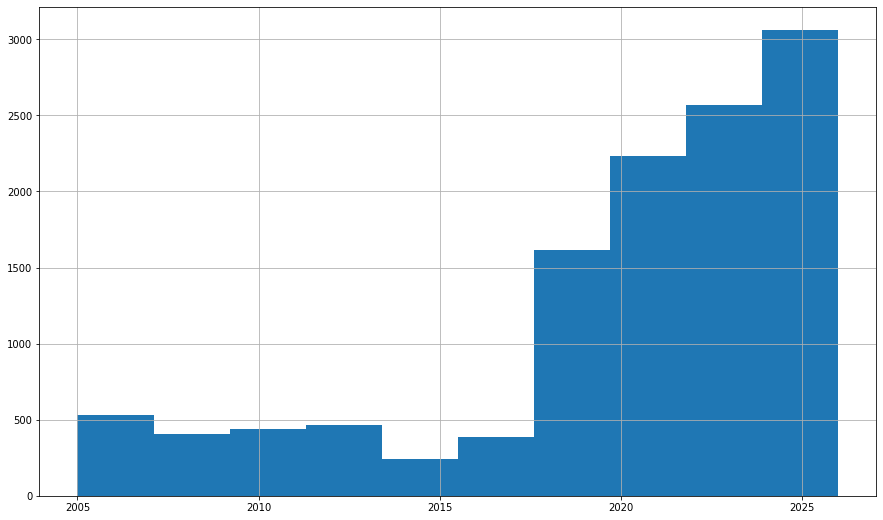

In [444]:
df['5ylater'] = pd.to_datetime(df['5ylater']) # df['새컬럼'] = pd.to_datetime(df['컬럼'])
df['5ylater'].dt.year.hist()


In [433]:
df

,comp,date,유동자산(천원),비유동자산(천원),유동부채(천원),비유동부채(천원),총자본(천원),매출액(천원),당기순이익(천원),영업활동으로인한현금흐름(천원),자기자본비율(%),매출총이익률(%),부채비율(%),당좌자산(천원),매출액증가율(전년동기)(%),총자산증가율(전년동기)(%),영업이익증가율(전년동기)(%),총자산회전율(회),총자산회전율(3년평균)(회),ROE(영업이익)(%),"ROE(영업이익,3년평균)(%)",매출채권(천원),재고자산(천원),mc,5ylater,kr_rate,us_rate,cpi
0,삼성전자,2000-12-31,1.467997e+10,1.965402e+10,2.486221e+10,4.773794e+09,1.678550e+10,4.352781e+10,6.192090e+09,5.169000e+09,36.16,36.50,176.56,9.955097e+09,35.65,59.09,68.53,1.15,1.03,60.48,57.62,3.813013e+09,4.724876e+09,26818934.0,2005-12-31,5.25,6.50,67.370
1,삼성전자,2001-12-31,2.687072e+10,2.524416e+10,2.356162e+10,8.154740e+09,2.039852e+10,4.644377e+10,3.370912e+09,4.645165e+09,39.14,29.68,155.48,2.325999e+10,6.70,12.26,-56.39,0.94,1.07,21.25,44.24,3.848180e+09,3.610732e+09,33785595.0,2006-12-31,4.00,1.75,69.501
2,삼성전자,2002-12-31,3.613295e+10,2.882204e+10,2.917989e+10,1.028240e+10,2.549270e+10,5.956866e+10,7.324642e+09,9.586457e+09,39.25,37.97,154.80,3.183604e+10,28.26,24.64,133.98,1.02,1.03,40.29,39.12,5.426944e+09,4.296907e+09,56567544.0,2007-12-31,4.25,1.25,72.096
3,삼성전자,2003-12-31,3.555514e+10,3.248661e+10,2.802051e+10,9.861517e+09,3.015971e+10,6.481746e+10,5.353068e+09,1.402537e+10,44.33,34.81,125.60,3.077393e+10,8.81,4.75,-31.90,0.97,0.98,22.63,28.00,6.315442e+09,4.781205e+09,73887253.0,2008-12-31,3.75,1.00,74.561
4,삼성전자,2004-12-31,3.199122e+10,3.701340e+10,2.610758e+10,6.496761e+09,3.640028e+10,8.196301e+10,1.016887e+10,1.643193e+10,52.75,35.39,89.57,2.618758e+10,26.45,1.42,86.79,1.20,1.08,35.34,32.37,6.774392e+09,5.803646e+09,71783992.0,2009-12-31,3.25,2.25,76.824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11946,세경하이테크,2020-12-31,7.890960e+07,1.287306e+08,6.557490e+07,1.047918e+07,1.315862e+08,2.199668e+08,-3.458658e+06,2.082791e+07,63.37,17.62,57.80,6.550985e+07,-21.82,0.59,-91.42,1.06,1.59,1.48,20.90,2.936643e+07,1.339975e+07,257708.0,2025-12-31,0.50,0.25,105.670
11947,에이치엘사이언스,2017-12-31,3.990583e+07,1.783114e+07,3.803268e+06,7.980100e+05,5.313569e+07,4.019722e+07,4.940098e+06,5.834980e+06,92.03,70.04,8.66,3.778706e+07,-1.78,5.78,-21.97,0.72,0.97,10.32,15.76,2.014926e+06,2.118766e+06,157228.0,2022-12-31,1.50,1.50,102.990
11948,에이치엘사이언스,2018-12-31,5.404686e+07,1.736479e+07,7.564188e+06,8.590000e+05,6.298846e+07,6.410847e+07,1.086477e+07,1.302172e+07,88.20,70.42,13.37,5.110186e+07,59.48,23.68,129.69,0.99,0.96,21.10,18.00,3.202881e+06,2.945002e+06,221701.0,2023-12-31,1.75,2.50,104.350
11949,에이치엘사이언스,2019-12-31,6.981067e+07,2.461176e+07,1.228654e+07,9.254510e+05,8.121043e+07,1.282609e+08,1.974234e+07,2.138018e+07,86.01,75.58,16.27,6.495372e+07,100.07,32.22,93.36,1.55,1.11,32.85,22.23,4.658608e+06,4.856954e+06,299455.0,2024-12-31,1.25,1.75,105.120


In [ ]:
# 2021용
#date에 따라 분리, index저장
# comp = df['comp']
df = df.drop(['5ylater'],axis = 1)
df


In [452]:
# 2020 12-31 date 분리
df = df[df['date'] == '2020-12-31']
df.reset_index(drop = True, inplace = True)
df_saved = df # 백업
comps = df.comp #
comps

In [460]:
df.drop(['comp','date'],axis = 1,inplace=True)

,comp,date,유동자산(천원),비유동자산(천원),유동부채(천원),비유동부채(천원),총자본(천원),매출액(천원),당기순이익(천원),영업활동으로인한현금흐름(천원),자기자본비율(%),매출총이익률(%),부채비율(%),당좌자산(천원),매출액증가율(전년동기)(%),총자산증가율(전년동기)(%),영업이익증가율(전년동기)(%),총자산회전율(회),총자산회전율(3년평균)(회),ROE(영업이익)(%),"ROE(영업이익,3년평균)(%)",매출채권(천원),재고자산(천원),mc,kr_rate,us_rate,cpi
0,삼성전자,2020-12-31,1.982156e+11,1.800201e+11,7.560435e+10,2.668335e+10,2.759480e+11,2.368070e+11,2.640783e+10,6.528701e+10,72.96,38.98,37.07,1.661724e+11,2.78,7.28,29.62,0.65,0.69,13.36,16.34,3.096506e+10,3.204314e+10,441842860.0,0.5,0.25,105.67
1,SK하이닉스,2020-12-31,1.657095e+10,5.460290e+10,9.072360e+09,1.019240e+10,5.190910e+10,3.190042e+10,4.758914e+09,1.231457e+10,72.93,33.89,37.11,1.043464e+10,18.19,9.08,84.34,0.47,0.54,10.04,21.11,4.931322e+09,6.136318e+09,71091221.0,0.5,0.25,105.67
2,NAVER,2020-12-31,1.054466e+10,6.469579e+09,7.911751e+09,8.473551e+08,8.255132e+09,5.304146e+09,8.449970e+08,1.447212e+09,48.52,100.00,106.10,1.054031e+10,21.76,38.33,5.22,0.36,0.43,16.47,16.98,0.000000e+00,4.344942e+06,47287661.0,0.5,0.25,105.67
3,카카오,2020-12-31,4.462924e+09,6.987396e+09,2.627553e+09,1.166098e+09,7.427729e+09,4.156816e+09,1.733597e+08,9.710965e+08,62.14,100.00,60.94,4.417111e+09,35.40,36.82,120.45,0.40,0.37,6.92,4.22,2.473745e+08,4.581360e+07,32245123.0,0.5,0.25,105.67
4,LG화학,2020-12-31,1.631970e+10,2.506919e+10,1.262422e+10,9.974235e+09,1.879044e+10,3.007651e+10,6.824080e+08,5.840832e+09,45.40,20.99,120.27,1.097001e+10,9.96,21.64,117.85,0.80,0.88,9.94,9.30,5.298365e+09,5.349688e+09,54260821.0,0.5,0.25,105.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,네오팜,2020-12-31,1.135515e+08,1.942630e+07,1.487660e+07,3.836180e+05,1.177175e+08,8.162535e+07,1.813086e+07,1.707376e+07,88.52,71.84,12.96,1.054617e+08,-1.94,8.34,-4.61,0.64,0.80,19.61,25.85,8.321963e+06,8.089751e+06,231131.0,0.5,0.25,105.67
370,경인양행,2020-12-31,2.631725e+08,2.419296e+08,2.162674e+08,6.045299e+07,2.283818e+08,3.293121e+08,-7.581553e+06,5.455166e+07,45.21,20.82,121.17,1.537520e+08,-8.22,6.99,-85.69,0.67,0.78,1.45,6.90,6.888931e+07,1.094205e+08,286471.0,0.5,0.25,105.67
371,F&F홀딩스,2020-12-31,5.221984e+08,2.956306e+08,2.428226e+08,2.328281e+07,5.517236e+08,8.376158e+08,8.535834e+07,1.546031e+08,67.46,67.67,48.23,3.646679e+08,-7.99,19.49,-18.68,1.12,1.34,23.68,28.18,7.048306e+07,1.575305e+08,1386126.0,0.5,0.25,105.67
372,세경하이테크,2020-12-31,7.890960e+07,1.287306e+08,6.557490e+07,1.047918e+07,1.315862e+08,2.199668e+08,-3.458658e+06,2.082791e+07,63.37,17.62,57.80,6.550985e+07,-21.82,0.59,-91.42,1.06,1.59,1.48,20.90,2.936643e+07,1.339975e+07,257708.0,0.5,0.25,105.67


In [351]:
# 2021이면 건너뛰기
#학습에 필요 없는 컬럼 제거
df = df.drop(['comp','date','5ylater'],axis = 1)

In [ ]:
# df.to_csv('df_bf_eda.csv')

In [437]:
# 2021
df.to_csv('2021_processed.csv')

In [ ]:
#2021 데이터 분리
df

## [여기부터]  5) 종속변수 생성

In [473]:
df = pd.read_csv('df_bf_eda.csv',index_col = 0)
df.head()
# 5년뒤의 - 현재 시점 시총
df['inc'] = df['5y'] - df['mc']
df.drop('5y',axis = 1, inplace =True)
df['inc']

0       72143420.0
1       69964611.0
2       34662770.0
3        3865006.0
4       49808468.0
           ...    
5427      141388.0
5428       85417.0
5429      113889.0
5430      131147.0
5431       97463.0
Name: inc, Length: 5432, dtype: float64

## 6) Train_test_split

### 통계적으로 유의한 변수만 추가

In [474]:
df.columns

Index(['유동자산(천원)', '비유동자산(천원)', '유동부채(천원)', '비유동부채(천원)', '총자본(천원)', '매출액(천원)',
       '당기순이익(천원)', '영업활동으로인한현금흐름(천원)', '자기자본비율(%)', '매출총이익률(%)', '부채비율(%)',
       '당좌자산(천원)', '매출액증가율(전년동기)(%)', '총자산증가율(전년동기)(%)', '영업이익증가율(전년동기)(%)',
       '총자산회전율(회)', '총자산회전율(3년평균)(회)', 'ROE(영업이익)(%)', 'ROE(영업이익,3년평균)(%)',
       '매출채권(천원)', '재고자산(천원)', 'mc', 'kr_rate', 'us_rate', 'cpi', 'inc'],
      dtype='object')

In [16]:
df = df[['유동자산(천원)','총자본(천원)', '당좌자산(천원)', 'mc', '비유동자산(천원)', '유동부채(천원)', '매출액(천원)', '당기순이익(천원)', '영업활동으로인한현금흐름(천원)', '매출채권(천원)', '재고자산(천원)','inc']]

### 거시경제 지표 제거

In [ ]:
df.drop(['kr_rate', 'us_rate', 'cpi'],axis = 1, inplace = True)

### -Neural Network 용 Min-Max Scaling

In [475]:
#Train, Test split
train_data = df.drop('inc',axis = 1)
target_data = df['inc']


# EDA, NN에 필요한 Min-Max-Scaling

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(train_data) #dataframe을 input으로 받고 array를 반환함.

df_scaled = pd.DataFrame(data = scaled, columns = train_data.columns)
df_scaled.index = train_data.index

#Train_test_split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_scaled, target_data, test_size=0.2,random_state = 0) 
x_train

,유동자산(천원),비유동자산(천원),유동부채(천원),비유동부채(천원),총자본(천원),매출액(천원),당기순이익(천원),영업활동으로인한현금흐름(천원),자기자본비율(%),매출총이익률(%),부채비율(%),당좌자산(천원),매출액증가율(전년동기)(%),총자산증가율(전년동기)(%),영업이익증가율(전년동기)(%),총자산회전율(회),총자산회전율(3년평균)(회),ROE(영업이익)(%),"ROE(영업이익,3년평균)(%)",매출채권(천원),재고자산(천원),mc,kr_rate,us_rate,cpi
2401,0.001944,0.001167,0.005439,0.000529,0.000531,0.002329,0.078320,0.093118,0.214226,0.145825,0.058160,0.001574,0.049492,0.067392,0.000820,0.169100,0.137800,0.092173,0.081930,0.005138,0.003678,0.006948,0.000000,0.058085,0.990132
1977,0.030034,0.035120,0.074519,0.029388,0.015134,0.015005,0.074718,0.096519,0.290614,0.042161,0.039470,0.026732,0.024535,0.043630,0.006660,0.088808,0.099874,0.008179,0.059719,0.053758,0.044498,0.002976,0.266667,0.018838,0.917920
4001,0.000521,0.000324,0.000929,0.000097,0.000350,0.000102,0.077832,0.093373,0.527252,0.263713,0.014875,0.000327,0.034320,0.056789,0.000459,0.096107,0.091024,0.052755,0.076811,0.000771,0.001476,0.000441,0.466667,0.018838,0.884368
5326,0.001534,0.000854,0.002329,0.000323,0.001002,0.000699,0.078398,0.092218,0.549874,0.346910,0.013595,0.001351,0.029593,0.047458,0.000540,0.130170,0.107459,0.079927,0.081549,0.004617,0.002398,0.000502,0.266667,0.018838,0.964968
5146,0.000192,0.000182,0.000099,0.000059,0.000261,0.000132,0.077923,0.093365,0.835859,0.465514,0.003296,0.000189,0.035093,0.068531,0.000651,0.072993,0.073325,0.034216,0.067905,0.000197,0.000262,0.000288,0.933333,0.646782,0.501538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,0.001867,0.000436,0.000664,0.000577,0.001261,0.001324,0.078525,0.093899,0.744423,0.132010,0.005746,0.002078,0.030523,0.054399,0.000518,0.121655,0.139064,0.020334,0.063746,0.001170,0.000855,0.000832,0.400000,0.000000,0.601701
3264,0.003757,0.014150,0.007110,0.009503,0.008141,0.010313,0.079707,0.092523,0.558923,0.233627,0.013113,0.001814,0.028623,0.048497,0.000349,0.138686,0.144121,0.027241,0.066607,0.001182,0.012841,0.005724,0.400000,0.018838,0.911853
1653,0.000669,0.002163,0.002049,0.001346,0.001095,0.001383,0.078362,0.094171,0.470749,0.169361,0.018575,0.000551,0.030626,0.058852,0.000575,0.097324,0.109987,0.033125,0.066640,0.001787,0.001260,0.001252,0.266667,0.018838,0.933796
2607,0.001582,0.001080,0.001625,0.000024,0.001588,0.000261,0.077959,0.093201,0.781987,0.237311,0.004673,0.001128,0.025302,0.048000,0.000253,0.076642,0.073325,0.022833,0.066028,0.002429,0.003722,0.006797,0.066667,0.018838,0.975620


### -Tree 계열 용 

그냥 아래꺼 쓰면 됨.

In [ ]:
#Train, Test split
train_data = df.drop('inc',axis = 1)
target_data = df['inc']


from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_data, target_data, test_size=0.2,random_state = 0) 
x_train

,유동자산(천원),비유동자산(천원),유동부채(천원),비유동부채(천원),총자본(천원),매출액(천원),당기순이익(천원),영업활동으로인한현금흐름(천원),자기자본비율(%),매출총이익률(%),부채비율(%),당좌자산(천원),매출액증가율(전년동기)(%),총자산증가율(전년동기)(%),영업이익증가율(전년동기)(%),총자산회전율(회),총자산회전율(3년평균)(회),ROE(영업이익)(%),"ROE(영업이익,3년평균)(%)",매출채권(천원),재고자산(천원),mc,5y,kr_rate,us_rate,cpi
2401,2.560004e+08,1.829317e+08,2.962757e+08,4.613667e+07,9.651974e+07,5.333427e+08,18885577.0,-6503440.0,21.99,16.53,354.76,1.719881e+08,59.70,34.77,47.65,1.40,1.13,40.59,34.04,1.419581e+08,8.401234e+07,1666195.0,1064902.0,1.50,0.50,100.220
1977,3.901349e+09,5.450645e+09,4.051311e+09,2.565046e+09,2.735638e+09,3.432364e+09,-100115581.0,168719116.0,29.25,6.40,241.86,2.884963e+09,-20.03,-8.19,1098.92,0.74,0.83,3.62,7.18,1.485425e+09,1.016386e+09,714719.0,952021.0,2.50,0.25,97.732
4001,7.126250e+07,5.216977e+07,5.111888e+07,8.454832e+06,6.385855e+07,2.424227e+07,2785073.0,6650622.0,51.74,28.05,93.29,3.755117e+07,11.23,15.60,-17.24,0.80,0.76,23.24,27.85,2.130095e+07,3.371133e+07,107406.0,91566.0,3.25,0.25,96.576
5326,2.027424e+08,1.343881e+08,1.272159e+08,2.822816e+07,1.816865e+08,1.606137e+08,21462824.0,-52835124.0,53.89,36.18,85.56,1.479588e+08,-3.87,-1.27,-2.69,1.08,0.89,35.20,33.58,1.275705e+08,5.478367e+07,122002.0,352473.0,2.50,0.25,99.353
5146,2.866504e+07,3.015575e+07,5.987192e+06,5.149387e+06,4.768422e+07,3.090308e+07,5786790.0,6264703.0,81.07,47.77,23.35,2.268944e+07,13.70,36.83,17.29,0.61,0.62,15.08,17.08,5.456298e+06,5.975602e+06,70685.0,239877.0,5.00,4.25,83.386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,2.459685e+08,6.962482e+07,3.674560e+07,5.040561e+07,2.284421e+08,3.035900e+08,25665249.0,33729042.0,72.38,15.18,38.15,2.264400e+08,-0.90,11.28,-6.61,1.01,1.14,8.97,12.05,3.232522e+07,1.952841e+07,201200.0,334359.0,3.00,0.13,86.837
3264,4.912198e+08,2.197246e+09,3.871175e+08,8.294640e+08,1.471884e+09,2.359415e+09,64725831.0,-37155674.0,54.75,25.11,82.65,1.979121e+08,-6.97,0.61,-37.14,1.15,1.18,12.01,15.51,3.266511e+07,2.933078e+08,1373157.0,1578655.0,3.00,0.25,97.523
1653,9.054477e+07,3.374520e+08,1.120034e+08,1.175160e+08,1.984773e+08,3.170468e+08,20294730.0,47737661.0,46.37,18.83,115.64,6.177460e+07,-0.57,19.33,3.63,0.81,0.91,14.60,15.55,4.939011e+07,2.877017e+07,301764.0,877928.0,2.50,0.25,98.279
2607,2.090176e+08,1.695228e+08,8.894235e+07,2.098548e+06,2.874996e+08,6.050177e+07,6969183.0,-2183641.0,75.95,25.47,31.67,1.239979e+08,-17.58,-0.29,-54.36,0.64,0.62,10.07,14.81,6.711410e+07,8.501974e+07,1630071.0,1159836.0,1.75,0.25,99.720


In [ ]:
# x_train, x_test 합치기
train_data = df.loc[x_train.index]

# 2.EDA

In [ ]:
# import os
# os.chdir('/gdrive/MyDrive/석사 수업/2학기/비즈니스 인포매틱스 세미나/프로젝트/2차 데이터 수집')
# df = pd.read_csv('df_bf_eda.csv', index_col = 0)
# df.head()

,유동자산(천원),비유동자산(천원),유동부채(천원),비유동부채(천원),총자본(천원),매출액(천원),당기순이익(천원),영업활동으로인한현금흐름(천원),자기자본비율(%),매출총이익률(%),부채비율(%),당좌자산(천원),매출액증가율(전년동기)(%),총자산증가율(전년동기)(%),영업이익증가율(전년동기)(%),총자산회전율(회),총자산회전율(3년평균)(회),ROE(영업이익)(%),"ROE(영업이익,3년평균)(%)",매출채권(천원),재고자산(천원),mc,5y,kr_rate,us_rate,cpi
0,1.467997e+10,1.965402e+10,2.486221e+10,4.773794e+09,1.678550e+10,4.352781e+10,6.192090e+09,5.169000e+09,36.16,36.50,176.56,9.955097e+09,35.65,59.09,68.53,1.15,1.03,60.48,57.62,3.813013e+09,4.724876e+09,26818934.0,98962354.0,5.25,6.50,67.370
1,2.687072e+10,2.524416e+10,2.356162e+10,8.154740e+09,2.039852e+10,4.644377e+10,3.370912e+09,4.645165e+09,39.14,29.68,155.48,2.325999e+10,6.70,12.26,-56.39,0.94,1.07,21.25,44.24,3.848180e+09,3.610732e+09,33785595.0,103750206.0,4.00,1.75,69.501
2,3.613295e+10,2.882204e+10,2.917989e+10,1.028240e+10,2.549270e+10,5.956866e+10,7.324642e+09,9.586457e+09,39.25,37.97,154.80,3.183604e+10,28.26,24.64,133.98,1.02,1.03,40.29,39.12,5.426944e+09,4.296907e+09,56567544.0,91230314.0,4.25,1.25,72.096
3,3.555514e+10,3.248661e+10,2.802051e+10,9.861517e+09,3.015971e+10,6.481746e+10,5.353068e+09,1.402537e+10,44.33,34.81,125.60,3.077393e+10,8.81,4.75,-31.90,0.97,0.98,22.63,28.00,6.315442e+09,4.781205e+09,73887253.0,77752259.0,3.75,1.00,74.561
4,3.199122e+10,3.701340e+10,2.610758e+10,6.496761e+09,3.640028e+10,8.196301e+10,1.016887e+10,1.643193e+10,52.75,35.39,89.57,2.618758e+10,26.45,1.42,86.79,1.20,1.08,35.34,32.37,6.774392e+09,5.803646e+09,71783992.0,121592460.0,3.25,2.25,76.824


## 상관관계 확인

In [ ]:
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq
#설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

#폰트
plt.rc('font', family='NanumBarunGothic') 

#안되면
#설치된 폰트 확인
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
font_list


#폰트
plt.rcParams['font.family'] = 'NanumBarunGothic' #히트맵은 잘됨

#여러번 쓸거면 코랩에서 드라이브에 넣기.
from matplotlib import font_manager, rc

# os.chdir('경로')
# font_name = font_manager.FontProperties(fname="NanumGothic.ttf").get_name()
# rc('font', family=font_name)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


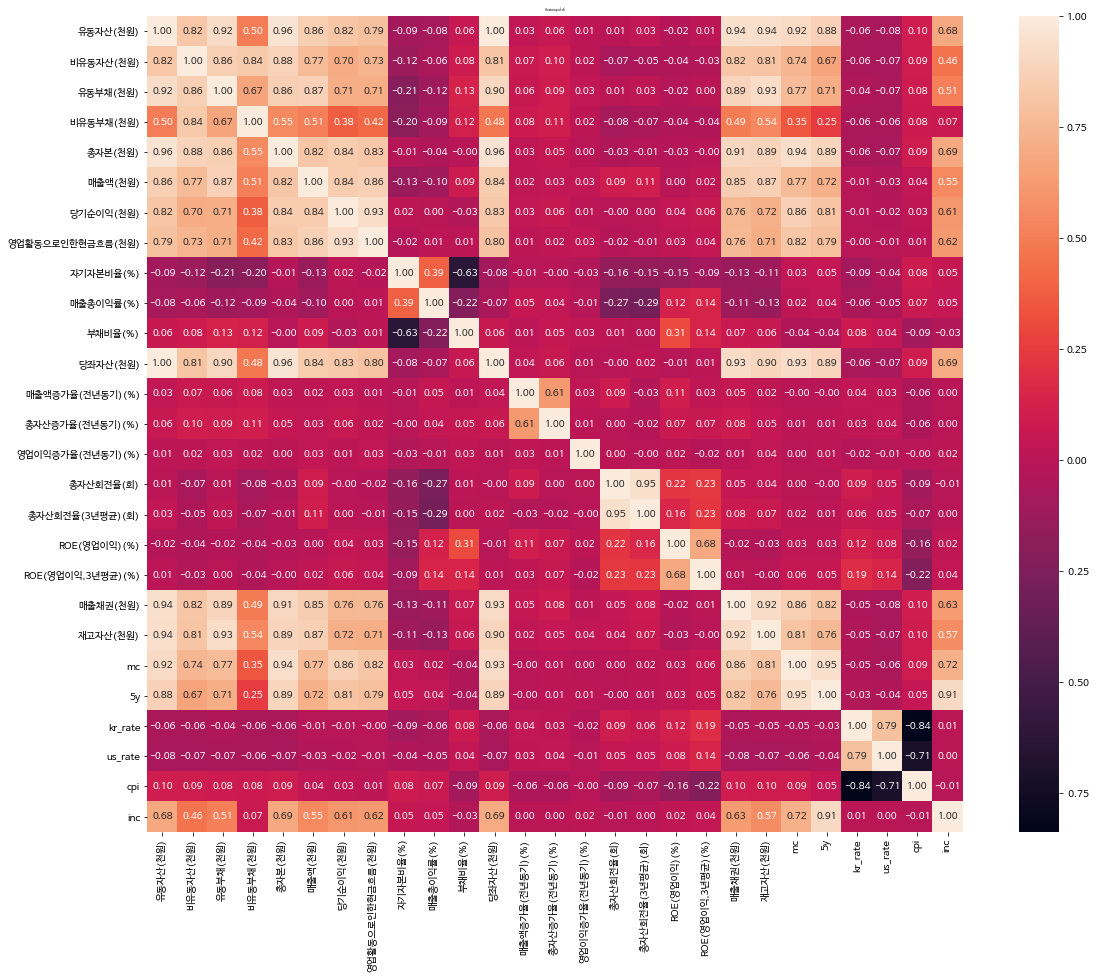

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(df_scaled.corr(), annot=True, fmt='.2f', square=True)
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.title('Heatmap of df', fontsize=3)

plt.show()

In [ ]:
train_data.columns

Index(['유동자산(천원)', '비유동자산(천원)', '유동부채(천원)', '비유동부채(천원)', '총자본(천원)', '매출액(천원)',
       '당기순이익(천원)', '영업활동으로인한현금흐름(천원)', '자기자본비율(%)', '매출총이익률(%)', '부채비율(%)',
       '당좌자산(천원)', '매출액증가율(전년동기)(%)', '총자산증가율(전년동기)(%)', '영업이익증가율(전년동기)(%)',
       '총자산회전율(회)', '총자산회전율(3년평균)(회)', 'ROE(영업이익)(%)', 'ROE(영업이익,3년평균)(%)',
       '매출채권(천원)', '재고자산(천원)', 'mc', '5y', 'kr_rate', 'us_rate', 'cpi', 'inc'],
      dtype='object')

## 한국, 미국금리, cpi 추이 비교

In [ ]:
int_cpi.index = int_cpi['date']
int_cpi = int_cpi.drop('date', axis = 1)
int_cpi = int_cpi.astype(float)
int_cpi

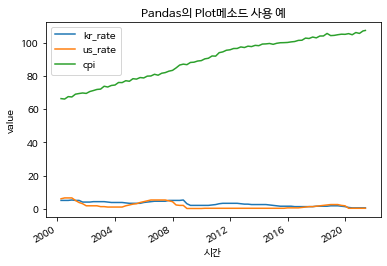

In [ ]:
#df시각화
int_cpi.plot()
plt.title("금리추이와 소비자물가지수")
plt.xlabel("시간")
plt.ylabel("value")
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(int_cpi) #dataframe을 input으로 받고 array를 반환함.

df_scaled = pd.DataFrame(data = scaled, columns = int_cpi.columns)
df_scaled.index = int_cpi.index
df_scaled

,kr_rate,us_rate,cpi
date,,,
2000-03-31,0.947368,0.921507,0.006432
2000-06-30,0.947368,1.000000,0.000000
2000-09-30,0.947368,1.000000,0.035402
2000-12-31,1.000000,1.000000,0.030565
2001-03-31,0.947368,0.764521,0.070827
...,...,...,...
2020-06-30,0.000000,0.018838,0.937370
2020-09-30,0.000000,0.018838,0.969531
2020-12-31,0.000000,0.018838,0.956715


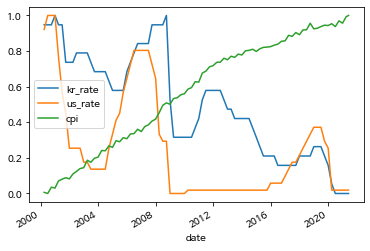

In [ ]:
df_scaled.plot()

# 3.Model Training

평가지표 저장

In [19]:
# research 관련 표기
res = 'stat' #without_macro, with_macro

In [20]:

#기존 모델 불러오기 
with open('/gdrive/MyDrive/석사 수업/2학기/비즈니스 인포매틱스 세미나/프로젝트/model/ev_df_stock','rb') as fr:
  ev_df = pickle.load(fr)
ev_df
# 모델 결과 저장 준비
ev_df_material = {
 'model':np.nan,
 'res':res,
 'ann_adj_r2_test':np.nan,
 'ann_mae_test':np.nan,
 'ann_rmse_test':np.nan,
 'rf_adj_r2_test':np.nan,
 'rf_mae_test':np.nan,
 'rf_rmse_test':np.nan,
 'xg_adj_r2_test':np.nan,
 'xg_mae_test':np.nan,
 'xg_rmse_test':np.nan,
 'xg_r2_test':np.nan}
ev_df_material



{'ann_adj_r2_test': nan,
 'ann_mae_test': nan,
 'ann_rmse_test': nan,
 'model': nan,
 'res': 'stat',
 'rf_adj_r2_test': nan,
 'rf_mae_test': nan,
 'rf_rmse_test': nan,
 'xg_adj_r2_test': nan,
 'xg_mae_test': nan,
 'xg_r2_test': nan,
 'xg_rmse_test': nan}

## 평가지표 함수

In [21]:
# RMLSLE도 추가한 버젼 --> 뺌. (다른 논문에서 활용하지 않음-->이는 새로 증명해야할 부분.)
from sklearn.metrics import make_scorer

# r2 sklearn꺼로 수정해서 다시 구현, mape sklearn꺼는 안됨. 없음. --> 수정, r2 squared 추가

def metrics(model,x_train,y_train,x_test,y_test,train_pred,test_pred):
  r2_train = np.round(r2_score(y_train, train_pred),2)
  r2_test = np.round(r2_score(y_test, test_pred),2)
  def adjusted_r_squared(X, Y, r2):

      n = len(Y)
      p = X.shape[1]
      adj_r = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

      return adj_r
  print("train set score(adj R square):",np.round(adjusted_r_squared(x_train, y_train,r2_train),2))
  print("test set score(adj R square):",np.round(adjusted_r_squared(x_test, y_test,r2_test),2),"\n")

  ev_df_material[model_name + '_adjr2_train'] = np.round(adjusted_r_squared(x_train, y_train,r2_train),2)
  ev_df_material[model_name + '_adjr2_test'] = np.round(adjusted_r_squared(x_test, y_test,r2_test),2)
  #y_train= np.array(y_train)
  #y_test = np.array(y_train)
  # MAE Mean absolute error --> MSE보다 특이치에 robust 절댓값이라서
  print("train set score(MAE):",np.round(mean_absolute_error(y_train, train_pred),2)) #.sklearnmetrics(y_true, y_pred)
  print("test set score(MAE):",np.round(mean_absolute_error(y_test, test_pred),2),"\n")
  
  ev_df_material[model_name + '_mae_train'] = np.round(mean_absolute_error(y_train, train_pred),2)
  ev_df_material[model_name + '_mae_test'] =np.round(mean_absolute_error(y_test, test_pred),2)
  
  # RMSE Root Mean Sqaured Error
  print("train set score(RMSE):",np.round(np.sqrt(mean_squared_error(y_train,train_pred)),2))
  print("test set score(RMSE):",np.round(np.sqrt(mean_squared_error(y_test,test_pred)),2),"\n")

  ev_df_material[model_name + '_rmse_train'] = np.round(np.sqrt(mean_squared_error(y_train,train_pred)),2)
  ev_df_material[model_name + '_rmse_test'] = np.round(np.sqrt(mean_squared_error(y_test,test_pred)),2)
  


In [22]:
# seed 고정
np.random.seed(0)
tf.random.set_seed(0)


## Neural Network

In [ ]:
#학습안될때 돌려보삼 0
#모델 만들기 
def build_model():
 model = keras.Sequential([
    layers.Dense(2, activation='relu', input_shape=[len(x_train.keys())]),
    layers.Dense(2, activation='relu'),
    layers.Dense(1)])
 optimizer = tf.keras.optimizers.RMSprop(0.01)
 model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
 return model

model = build_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 2)                 48        
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 3         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#학습안될때 돌려보삼 1
#모델 만들기 
def build_model():
 model = keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=[len(x_train.keys())]),
    layers.Dense(4, activation='relu'),
    layers.Dense(1)])
 optimizer = tf.keras.optimizers.RMSprop(0.01)
 model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
 return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 216       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#학습안될때 돌려보삼 2
#모델 만들기 
def build_model():
 model = keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=[len(x_train.keys())]),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1)])
 optimizer = tf.keras.optimizers.RMSprop(0.01)
 model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
 return model

model = build_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 8)                 192       
_________________________________________________________________
dense_31 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_32 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 5         
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [183]:
#학습안될때 돌려보삼 3
#모델 만들기 
def build_model():
 model = keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=[len(x_train.keys())]),
    layers.Dense(4, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1)])
 optimizer = tf.keras.optimizers.RMSprop(0.01)
 model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
 return model

model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 4)                 108       
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 5         
Total params: 173
Trainable params: 173
Non-trainable params: 0
_________________________________________________________________


In [184]:
#학습

#모델 저장할 주소
modelpath = '/gdrive/MyDrive/석사 수업/2학기/비즈니스 인포매틱스 세미나/프로젝트/model/{epoch:02d}-{val_loss:.4f}.hdf5'

#모델 저장조건
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss',verbose = 1, save_best_only = True)

#학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor = 'val_loss',patience = 30)

#모델 학습
history = model.fit(
  x_train, y_train,
  epochs= 2500, validation_split = 0.2, verbose=1,batch_size = 100, callbacks = [early_stopping_callback])  #Q epoch을 늘렸더니 갑자기 loss가 증가하고 학습자체가 잘 안됐다..?

Epoch 1/2500
35/35 [==============================] - 1s 7ms/step - loss: 82290558369792.0000 - mae: 1988640.2500 - mse: 82290558369792.0000 - val_loss: 238484367343616.0000 - val_mae: 2523935.2500 - val_mse: 238484333789184.0000
Epoch 2/2500
35/35 [==============================] - 0s 2ms/step - loss: 82290323488768.0000 - mae: 1988619.0000 - mse: 82290323488768.0000 - val_loss: 238483595591680.0000 - val_mae: 2523897.7500 - val_mse: 238483612368896.0000
Epoch 3/2500
35/35 [==============================] - 0s 2ms/step - loss: 82289560125440.0000 - mae: 1988547.6250 - mse: 82289568514048.0000 - val_loss: 238481548771328.0000 - val_mae: 2523786.7500 - val_mse: 238481548771328.0000
Epoch 4/2500
35/35 [==============================] - 0s 2ms/step - loss: 82287412641792.0000 - mae: 1988360.3750 - mse: 82287412641792.0000 - val_loss: 238475609636864.0000 - val_mae: 2523485.5000 - val_mse: 238475626414080.0000
Epoch 5/2500
35/35 [==============================] - 0s 2ms/step - loss: 822825

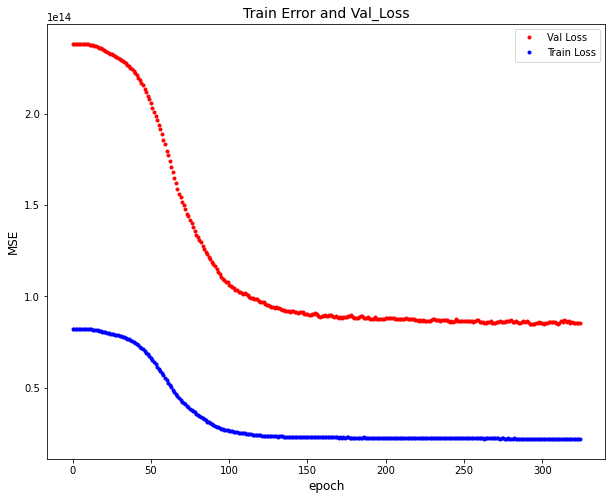

In [185]:
# 학습경과

y_vloss = history.history['val_loss']
y_mse = history.history['mse']

x_len = np.arange(len(y_mse))

plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(x_len, y_vloss, "o",c = "red", markersize = 3)


plt.plot(x_len, y_mse, "o", c = "blue", markersize = 3)


plt.title('Train Error and Val_Loss', fontsize=14)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)

plt.legend(['Val Loss','Train Loss'])


plt.show()


In [186]:
# Prediction
y_train = np.array(y_train).reshape(-1,1)


y_pred = model.predict(x_test)

# Evaluation Metrics
train_pred = model.predict(x_train) 
test_pred = model.predict(x_test)


model_name = 'ann'
metrics(model,x_train,y_train,x_test,y_test,train_pred,test_pred)

train set score(adj R square): 0.69
test set score(adj R square): 0.69 

train set score(MAE): 1672153.57
test set score(MAE): 1722253.59 

train set score(RMSE): 5871668.33
test set score(RMSE): 5066954.18 



In [187]:
#test, pred 비교용 - GrossUSA를 기준으로 정렬해서 그래프로 ㄱㄱ
y_pred_df = pd.DataFrame(test_pred,columns = ['pred'])# y_test
y_pred_df = y_pred_df.apply(lambda x: (np.round(x,0)))
y_test_df = pd.DataFrame(y_test)
y_test_df.columns = ['answer']
y_test_df.reset_index(drop = True, inplace = True)

pred_and_answer = pd.concat([y_pred_df,y_test_df],axis = 1,ignore_index=True)
pred_and_answer.columns = ['pred','answer']
pred_and_answer

,pred,answer
0,981.0,78952.0
1,981.0,-3796874.0
2,981.0,-611676.0
3,981.0,269308.0
4,981.0,-336885.0
...,...,...
1082,981.0,-10286478.0
1083,981.0,462243.0
1084,981.0,3764654.0
1085,981.0,123088.0


In [ ]:
pred_and_answer[:30]

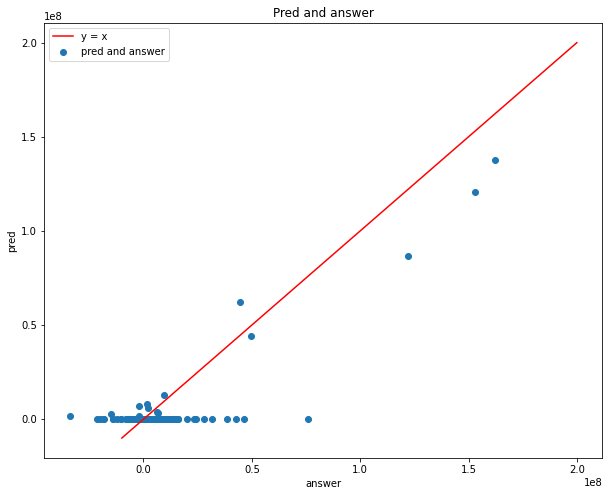

In [188]:
test_pred_2d = test_pred.reshape(-1,1)
y_test 
#위 두개로 그래프그리기

# x: y실제값, pred 값의 그래프
plt.scatter(y_test, test_pred_2d)
plt.title("Pred and answer")
plt.xlabel('answer')
plt.ylabel('pred')

x_values = np.arange(-10000000,200000000,1000)	# x축 지점의 값들
y_values = np.arange(-10000000,200000000,1000)# y축 지점의 값들
plt.plot(x_values, y_values,c = 'red')	# line 그래프를 그립니다 #plt.plot(x,y) 하면 직선
plt.legend(['y = x','pred and answer'])
plt.show()	# 그래프를 화면에 보여줍니다

## Random Forest

In [476]:
start = time.time()  # 시작 시간 저장

from sklearn.ensemble import RandomForestRegressor
# 하이퍼파라미터 튜닝 using grid search
from sklearn.model_selection import GridSearchCV
#RF gave max_features = n_features/3 for regression
regressor = RandomForestRegressor()
rf_param_grid =  {
    'n_estimators' : [200,400,800,1000],
    'max_depth' :[4,6,8,10,12],
    'min_samples_leaf' : [3,5,7,9],
    'min_samples_split' : [2,3,5,9,11,13]
}

# min_samples_leaf: 리프노드가 되기 위한 최소한의 샘플 수
# min_samples_split: 노드를 분할하기 위한 최소한의 데이터 수

grid_search = GridSearchCV(estimator = regressor, param_grid = rf_param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2) #,score = 'mean_squared_error'? 뭘로쟴..?
grid_search.fit(x_train,y_train)
grid_search.best_params_
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 보삼

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   40.7s


KeyboardInterrupt: ignored

In [ ]:
# model trainig

regressor = RandomForestRegressor(n_estimators = grid_search.best_params_['n_estimators'], max_depth = grid_search.best_params_['max_depth'],
                                  min_samples_leaf = grid_search.best_params_['min_samples_leaf'],
                                  min_samples_split = grid_search.best_params_['min_samples_split'], n_jobs=-1,random_state = 0)
regressor.fit(x_train,y_train)

# predict

y_train = np.array(y_train)
#test_pred = regressor.predict()
train_pred = regressor.predict(x_train)
test_pred = regressor.predict(x_test)


#eval metrics
model_name = 'rf'
metrics(regressor,x_train,y_train,x_test,y_test,train_pred,test_pred)



In [ ]:
#test, pred 비교용 - GrossUSA를 기준으로 정렬해서 그래프로 ㄱㄱ
y_pred_df = pd.DataFrame(test_pred,columns = ['pred'])# y_test
y_pred_df = y_pred_df.apply(lambda x: (np.round(x,0)))
y_test_df = pd.DataFrame(y_test)
y_test_df.columns = ['answer']
y_test_df.reset_index(drop = True, inplace = True)

pred_and_answer = pd.concat([y_pred_df,y_test_df],axis = 1,ignore_index=True)
pred_and_answer.columns = ['pred','answer']
pred_and_answer

In [ ]:
test_pred_2d = test_pred.reshape(-1,1)
y_test 
#위 두개로 그래프그리기

# x: y실제값, pred 값의 그래프
plt.scatter(y_test, test_pred_2d)
plt.title("Pred and answer")
plt.xlabel('answer')
plt.ylabel('pred')

x_values = np.arange(-10000000,200000000,1000)	# x축 지점의 값들
y_values = np.arange(-10000000,200000000,1000)# y축 지점의 값들
plt.plot(x_values, y_values,c = 'red')	# line 그래프를 그립니다 #plt.plot(x,y) 하면 직선
plt.legend(['y = x','pred and answer'])
plt.show()	# 그래프를 화면에 보여줍니다

## XG-Boost

In [177]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.05 ,0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [ 200, 500, 800,1000],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                      
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 4,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(x_train,y_train)

    return gsearch.best_params_
tuned = hyperParameterTuning(x_train, y_train)

Fitting 4 folds for each of 576 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed:  6.4min finished


In [178]:
#튜닝 후 다시

#xgb_model = XGBRegressor(tuned)
xgb_model = XGBRegressor(
    objective = tuned['objective'],
    colsample_bytree= tuned['colsample_bytree'],
    learning_rate= tuned['learning_rate'],
    max_depth= tuned['max_depth'],
    min_child_weight= tuned['min_child_weight'],
    n_estimators= tuned['n_estimators'],
    subsample= tuned['subsample'])

%time xgb_model.fit(x_train, y_train, early_stopping_rounds=10, eval_set=[(x_test, y_test)], verbose=True)

[0]	validation_0-rmse:8.75130e+06
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:8.2903e+06
[2]	validation_0-rmse:7.62642e+06
[3]	validation_0-rmse:7.2158e+06
[4]	validation_0-rmse:6.69476e+06
[5]	validation_0-rmse:6.23268e+06
[6]	validation_0-rmse:5.84791e+06
[7]	validation_0-rmse:5.56003e+06
[8]	validation_0-rmse:5.39135e+06
[9]	validation_0-rmse:5.19819e+06
[10]	validation_0-rmse:4.93209e+06
[11]	validation_0-rmse:4.76464e+06
[12]	validation_0-rmse:4.59119e+06
[13]	validation_0-rmse:4.37592e+06
[14]	validation_0-rmse:4.22904e+06
[15]	validation_0-rmse:4.18324e+06
[16]	validation_0-rmse:4.09845e+06
[17]	validation_0-rmse:4.05909e+06
[18]	validation_0-rmse:3.87591e+06
[19]	validation_0-rmse:3.78636e+06
[20]	validation_0-rmse:3.7041e+06
[21]	validation_0-rmse:3.65646e+06
[22]	validation_0-rmse:3.65604e+06
[23]	validation_0-rmse:3.59248e+06
[24]	validation_0-rmse:3.55519e+06
[25]	validation_0-rmse:3.5171e+06
[26]	validation_0-rmse:3.4038e+06
[27]	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=3, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.5, verbosity=1)

In [179]:
#test, pred 비교용 - GrossUSA를 기준으로 정렬해서 그래프로 ㄱㄱ
y_pred_df = pd.DataFrame(test_pred,columns = ['pred'])# y_test
y_pred_df = y_pred_df.apply(lambda x: (np.round(x,0)))
y_test_df = pd.DataFrame(y_test)
y_test_df.columns = ['answer']
y_test_df.reset_index(drop = True, inplace = True)

pred_and_answer = pd.concat([y_pred_df,y_test_df],axis = 1,ignore_index=True)
pred_and_answer.columns = ['pred','answer']
pred_and_answer

,pred,answer
0,128839.0,78952.0
1,-3061192.0,-3796874.0
2,-564479.0,-611676.0
3,131558.0,269308.0
4,-294425.0,-336885.0
...,...,...
1082,-8910158.0,-10286478.0
1083,137181.0,462243.0
1084,3770041.0,3764654.0
1085,129370.0,123088.0


In [180]:
#test_pred = regressor.predict()
train_pred = xgb_model.predict(x_train)
test_pred = xgb_model.predict(x_test)



#eval metrics
model_name = 'xg'
metrics(xgb_model,x_train,y_train,x_test,y_test,train_pred,test_pred)


train set score(adj R square): 0.99
test set score(adj R square): 0.96 

train set score(MAE): 405296.22
test set score(MAE): 538701.93 

train set score(RMSE): 1114904.03
test set score(RMSE): 1938969.31 



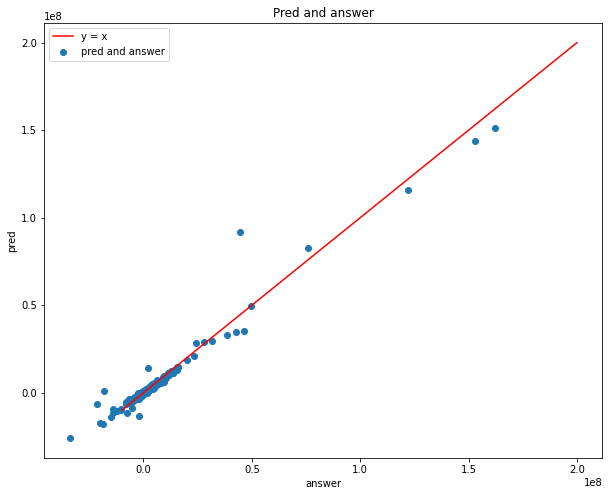

In [181]:
test_pred_2d = test_pred.reshape(-1,1)
y_test 
#위 두개로 그래프그리기

# x: y실제값, pred 값의 그래프
plt.scatter(y_test, test_pred_2d)
plt.title("Pred and answer")
plt.xlabel('answer')
plt.ylabel('pred')

x_values = np.arange(-10000000,200000000,1000)	# x축 지점의 값들
y_values = np.arange(-10000000,200000000,1000)# y축 지점의 값들
plt.plot(x_values, y_values,c = 'red')	# line 그래프를 그립니다 #plt.plot(x,y) 하면 직선
plt.legend(['y = x','pred and answer'])
plt.show()	# 그래프를 화면에 보여줍니다

In [182]:
#끝나면 나는 소리
# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')


sec = time.time() - start
min = int(sec // 60)
sec = int(sec % 60)

print(f"time :{min}분{sec}초" )  # 현재시각 - 시작시간 = 실행 시간

time :74분25초


### Train 결과 저장

In [39]:
ev_df_material

{'ann_adj_r2_test': nan,
 'ann_adjr2_test': 0.66,
 'ann_adjr2_train': 0.63,
 'ann_mae_test': 1789476.61,
 'ann_mae_train': 1743060.51,
 'ann_rmse_test': 5353936.62,
 'ann_rmse_train': 6458976.44,
 'model': nan,
 'res': 'stat',
 'rf_adj_r2_test': nan,
 'rf_adjr2_test': 0.7,
 'rf_adjr2_train': 0.85,
 'rf_mae_test': 1715105.39,
 'rf_mae_train': 1299464.23,
 'rf_rmse_test': 5057821.65,
 'rf_rmse_train': 4058590.8,
 'xg_adj_r2_test': nan,
 'xg_adjr2_test': 0.75,
 'xg_adjr2_train': 0.94,
 'xg_mae_test': 1594360.28,
 'xg_mae_train': 972361.77,
 'xg_r2_test': nan,
 'xg_rmse_test': 4583046.51,
 'xg_rmse_train': 2544615.44}

# 저장하기 전에 조심

In [40]:
ev_df_material
new_df = pd.DataFrame(data = ev_df_material, index = ['0']) # 이번 모델들 돌려서 얻은 성능df
new_df
new_df = new_df.dropna(axis = 1)

ev_df = ev_df.append(new_df)
ev_df = ev_df.dropna(axis = 1)
ev_df.reset_index(drop = True, inplace = True)
ev_df
# ev_df.set_index(keys = 'rv_star',drop = True,inplace = True)

# ev_df = ev_df.reset_index()


,res,ann_mae_test,ann_rmse_test,rf_mae_test,rf_rmse_test,xg_mae_test,xg_rmse_test,ann_adjr2_train,ann_adjr2_test,ann_mae_train,ann_rmse_train,rf_adjr2_train,rf_adjr2_test,rf_mae_train,rf_rmse_train,xg_adjr2_train,xg_adjr2_test,xg_mae_train,xg_rmse_train
0,without_macro,1734938.25,5115614.78,422492.67,2629969.59,575878.71,2073498.51,0.67,0.68,1722793.35,6110700.63,0.93,0.92,280204.52,2773989.35,0.99,0.95,416848.37,1160505.34
0,with_macro,1708523.03,5000728.44,420363.81,2627079.59,538701.93,1938969.31,0.71,0.70,1650716.67,5695534.57,0.93,0.92,274677.42,2737151.14,0.99,0.96,405296.22,1114904.03
0,stat,1789476.61,5353936.62,1715105.39,5057821.65,1594360.28,4583046.51,0.63,0.66,1743060.51,6458976.44,0.85,0.70,1299464.23,4058590.80,0.94,0.75,972361.77,2544615.44


In [55]:

#저장. onlyonce.
with open('/gdrive/MyDrive/석사 수업/2학기/비즈니스 인포매틱스 세미나/프로젝트/model/ev_df_stock','wb') as fw:
  pickle.dump(ev_df,fw)


# 4.Model comparison

In [ ]:


# 'ann_adj_r2_test', 'rf_adj_r2_test', 'xg_adj_r2_test'
# 'ann_mae_test', 'rf_mae_test', 'xg_mae_test'
# 'ann_rmse_test', 'rf_rmse_test', 'xg_rmse_test'
# #.

### 1) 거시경제 지표 추가/미 추가 성능 비교

In [211]:
met = 'mae' #'adjr2' 'rmse' 'adjr2'

In [212]:

# met = 'adjr2' #rmse adjr2
colm = ['res','ann_'+met+'_test','rf_'+met+'_test','xg_'+met+'_test']


temp = ev_df[(ev_df['res'] == 'without_macro') | (ev_df['res'] == 'with_macro')] # 거시 경제 지표 관련 row만 남기기
temp_df = temp[colm]
# temp_df.index = ev_df['rv_star']
temp_df

temp_picked = temp_df
list(temp_df.T.loc['res'])
t = temp_df.T
t.columns = list(temp_df.T.loc['res'])
t.drop('res',inplace = True)
t
macro = t
macro

,without_macro,with_macro
ann_mae_test,1.73494e+06,1.70852e+06
rf_mae_test,422493,420364
xg_mae_test,575879,538702


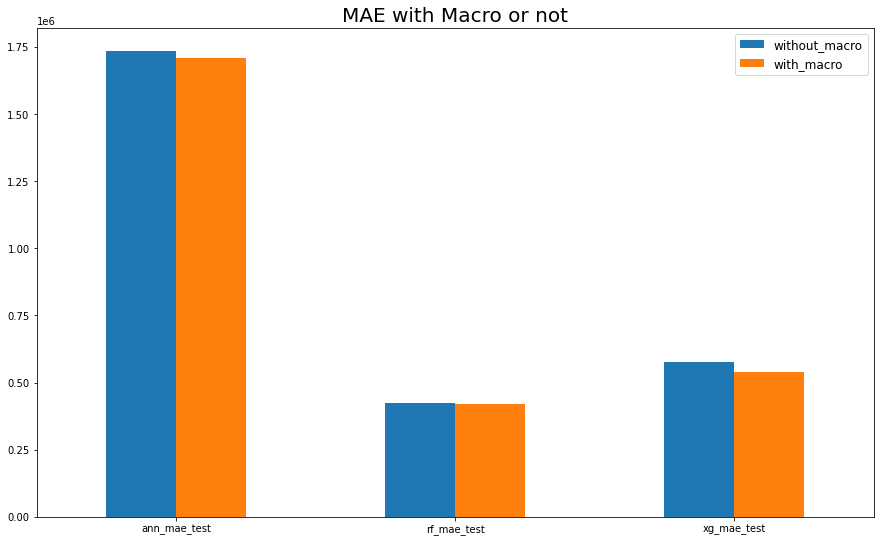

In [213]:

plt.rcParams['figure.figsize'] = [15, 9]


# Dodged Bar Chart by pandas

t.plot(kind='bar', rot=0)

plt.title('MAE with Macro or not', fontsize=20) #rmse

plt.legend(fontsize='12')

plt.show()



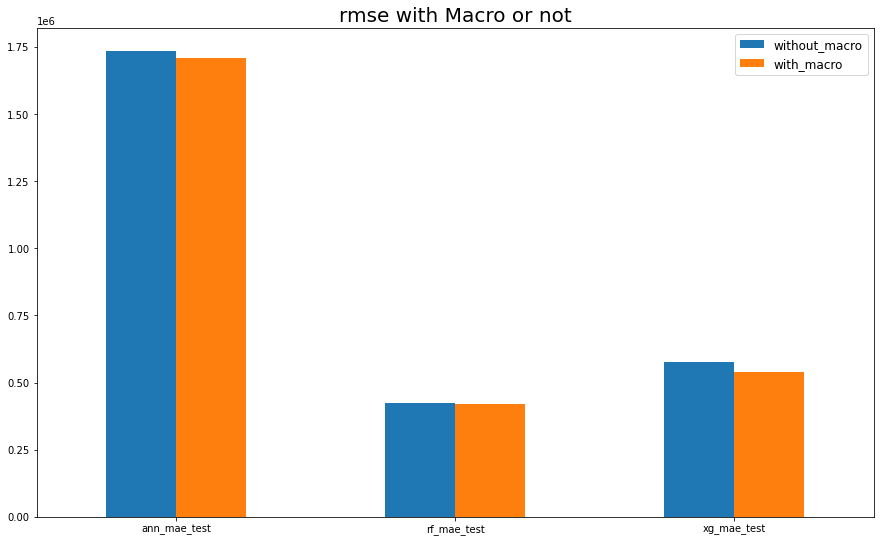

In [214]:

plt.rcParams['figure.figsize'] = [15, 9]


# Dodged Bar Chart by pandas

t.plot(kind='bar', rot=0)

plt.title('rmse with Macro or not', fontsize=20) #rmse

plt.legend(fontsize='12')

plt.show()



### 2) 통계적으로 유의한 변수 추가/제거 후 ML 성능 비교

In [215]:
ev_df


# met = 'adjr2' #rmse adjr2
colm = ['res','ann_'+met+'_test','rf_'+met+'_test','xg_'+met+'_test']


temp = ev_df[(ev_df['res'] == 'without_macro') | (ev_df['res'] == 'stat')] # 거시 경제 지표 관련 row만 남기기
temp_df = temp[colm]
# temp_df.index = ev_df['rv_star']
temp_df

temp_picked = temp_df
list(temp_df.T.loc['res'])
t = temp_df.T
t.columns = list(temp_df.T.loc['res'])
t.drop('res',inplace = True)
t['baseline'] = t['without_macro']
stat = t[['baseline','stat']]


stat


,baseline,stat
ann_mae_test,1.73494e+06,1.78948e+06
rf_mae_test,422493,1.71511e+06
xg_mae_test,575879,1.59436e+06


### 3) 가장 성능이 좋은 모델 확인

In [216]:
# Baseline, 거시경제지표 추가, 통계적으로 유의한 변수 추가한 경우 모델 성능 비교.
# 1) adjr2 
conc = pd.concat([stat,macro],axis = 1)
conc.drop('without_macro',axis = 1, inplace = True)
conc = conc[['baseline',	'with_macro','stat']]
temp_picked= conc.T

temp_picked = temp_picked.reset_index()
temp_picked

,index,ann_mae_test,rf_mae_test,xg_mae_test
0,baseline,1.73494e+06,422493,575879
1,with_macro,1.70852e+06,420364,538702
2,stat,1.78948e+06,1.71511e+06,1.59436e+06


In [217]:
temp_picked

,index,ann_mae_test,rf_mae_test,xg_mae_test
0,baseline,1.73494e+06,422493,575879
1,with_macro,1.70852e+06,420364,538702
2,stat,1.78948e+06,1.71511e+06,1.59436e+06


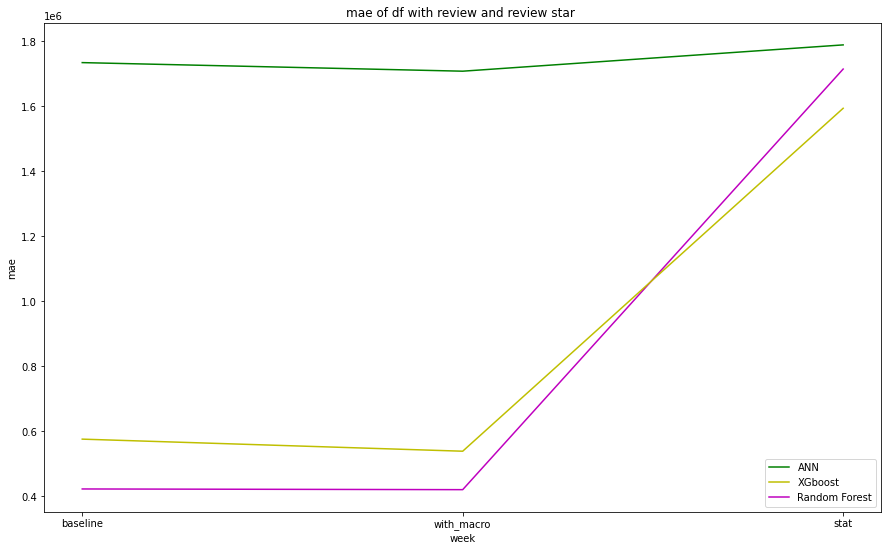

In [218]:
#'adj_r2'

# 시각화 - 선으로 그림. 
plt.title(met+" of "+"df with "+rv_star+" ")
plt.xlabel('week')
plt.ylabel(met)

# 변수, <--를 함으로써 legend에 handles를 제어할 수 있게 됨.
# base_line = plt.plot(temp_picked['index'],temp_picked['lr_'+met+'_test'],color = 'b',label = 'Linear Regression')

ann, = plt.plot(temp_picked['index'],temp_picked['ann_'+met+'_test'],color = 'g',label = 'ANN')
rf, = plt.plot(temp_picked['index'],temp_picked['rf_'+met+'_test'],color = 'm',label = 'Random Forest') 
xg, = plt.plot(temp_picked['index'],temp_picked['xg_'+met+'_test'],color = 'y',label = 'XGboost')



plt.legend(handles=[ann,xg,rf])


plt.show()

In [162]:
macro

,without_macro,with_macro
ann_adjr2_test,0.68,0.7
rf_adjr2_test,0.92,0.92
xg_adjr2_test,0.95,0.96
